In [1]:
import sys
import random
import math
import numpy as np
import pandas as pd
import scipy.optimize
from scipy.interpolate import UnivariateSpline
import scipy.stats as stats
from scipy.stats import t
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
import statsmodels.api as sm

In [2]:
# sys.path.append("/Users/omarkhalil/Desktop/Universidad/TFG/Simulacion_Omar/stochastic/stochastic/processes/continuous")
import fractional_brownian_motion

In [4]:
def multifractal_measure_det(kmax,  m00, m11, b = 2, m = 5, coef = False, graf1 = False, test0 = False, test1 = False, test2 = False, test3 = False):
    """
    Parameters
    ----------
    kmax : int
        Maximum iteration number.
    m00 : float
        Coefficient m00.
    m11 : float
        Coefficient m11.
    b : int, optional
        Base of the cascade, default is 2.
    m : int, optional
        Number of points in each interval, default is 5.
    coef : bool, optional
        If True, return coefficients, default is False.
    graf1 : bool, optional
        If True, plot the deterministic multifractal measure, default is False.
    test0 : bool, optional
        If True, plot the f(alpha) graph for the kmax iteration, default is False.
    test1 : bool, optional
        If True, test whether log(funcion_particion)/log(eps) are straight lines, default is False.
    test2 : bool, optional
        If True, test the calculation of f(alpha) using the moment method, default is False.
    test3 : bool, optional
        If True, test the convergence of the histogram method to the Monte Carlo method in terms of error, default is False.

    Returns
    -------
    None
    """
    
    # Creamos la función teórica del paper:

    def f1(alpha, m00, m11):
        a = max(m00, m11)
        alpha_min = -np.log2(a)
        alpha_max = -np.log2(1 - a)
        return -(alpha_max - alpha)/(alpha_max - alpha_min)*np.log2((alpha_max - alpha)/(alpha_max - alpha_min))-(alpha - alpha_min)/(alpha_max - alpha_min)*np.log2((alpha - alpha_min)/(alpha_max - alpha_min))


    # Algoritmo principal:

    # 1. Generamos todos los pesos:
    lista_general = [] 
    for k in range(kmax):
        lista_coeficientes = []
        for _ in range(2**k):
            lista_coeficientes.append(np.array([m00,m11]))
        lista_general.append(lista_coeficientes)


    """
     2. Ahora procedemos a multiplicar en cascada, el razonamiento
     es el siguiente. Al primer elemento de la primera tupla lo
     multiplico por la primera tupla de la segunda, al segundo elemento
     de la primera tupla por la segunda tupla de la segunda y así. Cuando 
     tenga todos los elementos de la segunda multiplicados por los
     de la primera pasamos a multiplicar los de la tercera tupla 
     por los de la segunda ya multiplicados. Recordemos que las tuplas 
     y los arrays son objetos mutables. Como todo el código, este algoritmo
     para generar la cascada es genuino, por lo que no está todo lo optimizado
     que pudiera estar. 
    """

    for i in range(kmax- 1):
        # Hacemos la lista lista i plana
        lista_general[i] = [item for sublist in lista_general[i] for item in sublist]
        # Multiplicamos a cada uno de sus elementos por una sublista entera de la 
        # siguiente sublista:
        for j in range(len(lista_general[i])):
            a = lista_general[i][j]* lista_general[i + 1][j]
            lista_general[i + 1][j] = a
    lista_general[-1] = [item for sublist in lista_general[-1] for item in sublist]
    """
    Ahora la lista lista_general contine en listas los valores de todos
    los outputs de la función medida multifractal random (si los pesos
    los ponemos deterministas pues serán los normales). 
    Además, por cómo hemos diseñado el algoritmo, tenemos la suerte de saber que
    el subintervalo i-ésimo en una iteración k tiene asignado el valor 
    de salida de la lista_general que se encuentra en la k-esima sublista de la 
    lista y en la posición i-ésima. 

    Para b = 2 existen otras formas más elegantes a nivel matemático de 
    calcular estos pesos. Por ejemplo, ya que en b = 2 los intervalos que
    se generan son los llamados intervalos diádicos (mirar medidas multifractales),
    una forma de hallar la medida es utilizando la representación binaria del
    primer elemento de cada uno de los intervalos, que comparten una relación 
    con el cómo están ordenados los intervalos (en forma de cascada) pero es algo 
    que computacionalmente es complejo de seguir para el caso aleatorio. 

    """
    # lista_general tiene por tanto las medidas de todos los intervalos en todas las etapas k
    # Esto se debe a que tal y como está generada el modelo de la cascada el valor de la 
    # medida es simplemente multiplicar por los valores de cada uno de los pesos. 

    if coef:
        return lista_general

    if graf1:
        intervalos = [np.linspace(i*b**(-kmax), (i+1)*b**(-kmax), m) for i in range(b**kmax)]
        # Multiplicamos el output por 2**k para conservar la masa y no el valor real de la
        # medida: 
        output = [2**(kmax)*coef* np.ones(m) for coef in lista_general[-1]]
        x = np.array([item for sublist in intervalos for item in sublist])
        y = np.array([item for sublist in output for item in sublist])
        plt.plot(x, y, linewidth = 0.5)
        plt.title(rf"Medida multifractal determinista renormalizada en un factor $2^k$" + f"\n en la iteración k = {kmax}" 
            + "\ncon " + fr"pesos $m_0$ = {m00}, $m_1$ = {m11}")
        plt.xlim(0,1)
        plt.ylim(0, np.amax(y)+ 0.1)
        plt.grid(True, linestyle="dashdot")
        plt.savefig('Medida_multifractal_det.png', dpi=300)
        plt.show()


    if test0 :
        # Aprovechamos que tenemos todos los valores de las medidas
        # en las iteraciones k previas en lista_general. Por tanto, lo único que se
        # debe hacer es hallar los coeficientes gruesos de Holder de cada elemento 
        # de cada sublista y calcular finalmente el histograma:
        # 1. Creamos la lista con los coeficientes Holder de cada iteración:
        bins1 = kmax - 1
        holder = [np.log(np.array(lista_general[i]))/np.log(2**(-(i+1))) for i in range(kmax)]
        # 2. Creamos el histograma solo de la última sublista (es la que nos interesa):
        hist, bin_edges = np.histogram(holder[-1], bins = bins1)
        # Calculamos f(alha) como nos muestra en el algoritmo:
        #x = [x + (bin_edges.tolist()[1]- bin_edges.tolist()[0])/2 for x in bin_edges.tolist()] # Realmente es innecesario, pero por hacerlo más bonito. 
        # Probamos analizando alpha en el punto de más de la izquierda:
        x = [x - (bin_edges.tolist()[1]- bin_edges.tolist()[0])/2 for x in bin_edges.tolist()] # Realmente es innecesario, pero por hacerlo más bonito. 
        y = -np.log(hist)/np.log(2**(-(kmax-1)))
        #plt.plot(x[1:], y)
        # Creamos el dominio de la función f(alpha) teórica para ser representada. 
        a = max(m00, m11)
        alpha_min = -np.log2(a)
        alpha_max = -np.log2(1 - a)
        x2 = np.linspace(alpha_min+0.01, alpha_max-0.01, 1000)
        #plt.plot(x2, f1(x2, m00, m11))
        #plt.xlabel('alpha')
        #plt.ylabel('f(alpha)')


        # Fijamos el tamaño de la letra del plot:
        plt.rcParams.update({'font.size': 12})

        #plt.style.use('dark_background')
        #plt.style.use('default')

        # Fijamos el tamaño de la caja del plot:
        plt.rcParams['figure.figsize'] = [8, 8]
        figure, axis = plt.subplots(1)


        axis.plot(x2, f1(x2, m00, m11), label = "funcion teórica")
        axis.plot(x[1:], y, label = "funcion numérica")
        axis.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=1)
        axis.set_title('f(alpha) experimental vs teórica \npor el método del histograma')
        axis.set_xlabel("alpha")
        axis.set_ylabel("f(alpha)")
        axis.grid(True, linestyle = 'dashdot')
        figure.set_facecolor('#EAEAEA')
        plt.savefig('f_alpha-hist.png', dpi=300)
        plt.show()

        
        print(f'Los valores alpha min y alpha max son respectivamente: {-np.log2(m00)}, {-np.log2(m11)}. Que como vemos coinciden con los valores experimentales. \n El máximo es {np.amax(y)} y los alphas experimentales son {x[0]} y {x[-1]}')
    
    
    if test1:
        # Vamos a comprobar el apartado (c) del método de los momentos. Vamos a ver si se generan lineas rectas. 

        # Pedimos un intervalo:
        # a = input("Por favor introduzca límite inferior:")
        # b = input("Por favor introduzca límite superior:")
        a = -20
        b = 20
        npuntos = 10
        h = (b - a)/npuntos # Tamaño del intervalo entre dos puntos. Nos servirá para la derivada (su definición normal como el límite), h no puede ser 
        # arbitrariamente pequeño, tiene que ser del tamaño de f(x + h).
        # Estudiamos para un conjunto de q's determinados:
        interval = np.linspace(a, b, npuntos)
        # Creamos una nueva variable con los datos de la lista_general pero con arrays en vez de listas. 
        medidas = [np.array(sublist) for sublist in lista_general]
        # Creammos una lista cuyos elementos son la función de partición para cada q en cada uno de los k
        # hasta llegar a kmax. Esta lista tendrá por tanto muchísimas funciones de partición:
        funciones_particion = [[np.sum(submedidas**q) for submedidas in medidas] for q in interval]
        # funciones_particion = [[np.sum(submedidas**q) for submedidas in medidas] for q in interval]
        # Hallamos la función de partición, que se define (en el límite eps --> 0), como la pendiente de la log/log que se muesta aquí abajo. 
        # En los apuntes se escribe con \sim porque es similar hasta el límite, donde se cumple la igualdad:


        # Fijamos el tamaño de la letra del plot:
        plt.rcParams.update({'font.size': 12})

        #plt.style.use('dark_background')
        #plt.style.use('default')

        # Fijamos el tamaño de la caja del plot:
        plt.rcParams['figure.figsize'] = [8, 8]
        """
        figure, axis = plt.subplots(1)
        for k in range(kmax):
            axis.scatter([np.log(2**(-(k + 1)))]*npuntos, np.log(funciones_particion[k:k+npuntos]), s = 0.5, label = "Test")
        """
        fig, ax = plt.subplots(figsize=(12, 8))
        for i, q in enumerate(interval):
            ax.plot([np.log10(2**((i+1))) for i in range(len(funciones_particion[i]))], np.log10(funciones_particion[i]/funciones_particion[i][0]))


        #axis.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=1)
        ax.set_title(r"Función de partición normalizada $log_{10}(S_q(\Delta t))$ vs. $log(\Delta t)$ para diferentes valores q.", fontsize=16, fontweight='bold')
        ax.set_ylabel(r"$log_{10}(S_q(\Delta t))$", fontsize=12, fontweight='bold')
        ax.set_xlabel(r"$log_{10}(\Delta t)$", fontsize=12, fontweight='bold')
        ax.grid(True, linestyle = 'dashdot')

        fig.set_facecolor('#EAEAEA')
        plt.savefig('funciones_parcicion.png', dpi=300)

        plt.show()
    

    if test2:
        # Pedimos un intervalo:
        # a = input("Por favor introduzca límite inferior:")
        # b = input("Por favor introduzca límite superior:")
        a = -5
        b = 5
        npuntos = 10000
        h = (b - a)/npuntos # Tamaño del intervalo entre dos puntos. Nos servirá para la derivada (su definición normal como el límite), h no puede ser 
        # arbitrariamente pequeño, tiene que ser del tamaño de f(x + h).
        # Estudiamos para un conjunto de q's determinados:
        qs = np.linspace(a, b, npuntos)
        deltas = [np.log(2**(-(k+1))) for k in range(kmax)]
        # Creamos una nueva variable con los datos de la lista_general pero con arrays en vez de listas. 
        #medidas = [np.array(sublist) for sublist in lista_general]
        medidas = [np.array(sublist) for sublist in lista_general]
        # Creammos una lista cuyos elementos son la función de partición para cada q en el kmax (sumamos las medidas elevadas a la q para la última lista)
        partition_functions = [np.array([np.sum(submedidas**q) for submedidas in medidas]) for q in qs]
        # Ahora normalizadas respecto al primer valor de cada una de las funciones:
        partition_functions_norm = [np.log(funcion/funcion[0]) for funcion in partition_functions]
        # Hallamos la función de partición, que se define (en el límite eps --> 0), como la pendiente de la log/log que se muesta aquí abajo. 
        # En los apuntes se escribe con \sim porque es similar hasta el límite, donde se cumple la igualdad:

        tau = [(funcion[1] - funcion[0])/(deltas[1] - deltas[0]) for funcion in partition_functions_norm]


        # En caso de que nos interesara hacer un análisis más exhasutivo a diferentes eps (en este caso solo nos hemos quedado con el último,
        # deberemos reformular el código, pero no es nada complicado)


        # Vamos a calcular la derivada mediante splines cúbicos por una cuestión de precisión frente a la derivada numérica:
        intervalo1 = np.linspace(qs[0], qs[-1], 1000)
        spline = UnivariateSpline(qs, tau)
        derivada1 = spline.derivative()(intervalo1)
        legendre1 = intervalo1*derivada1 - spline(intervalo1)

        # Calculamos los intervalos de confianza de la forma en la que me ha explicado Juan José:

        # 1. Hallamos todas las taus posibles (todas las lineas verticales y no el promedio de ellas), 
        # para ello hallamos la pendiente para cada una de las tau presuponiendo que nacen desde 0 
        # (esta presuposición es correcta porque se cumple la hipótesis nula y los intervalos de confianza
        # de las curvas ajustadas por OLS contienen a 0), (f(x) - f(0))/(x - 0), que se manifiesta como:




            
        # Ploteamos:

        # plt.style.use('dark_background')
        figure = plt.figure(figsize=(17, 8))

        # Los intervalos de confianza de la pendiente son tan pequeños que no se visualizan.
        ax1 = plt.subplot2grid((2, 4), (0, 0), colspan=2)
        ax1.plot(intervalo1, spline(intervalo1), lw=2, color='blue')
        ax1.set_title(r"Momento $\tau$")
        ax1.set_xlabel("q, que son las pendientes de f(alpha)")
        ax1.set_ylabel(r"$\tau$")
        ax1.grid(True, linestyle='dashdot')
        ax1.set_ylim(-1,3.5)
        ax1.set_xlim(0,4)


        ax2 = plt.subplot2grid((2, 4), (1, 0), colspan=2)
        ax2.plot(intervalo1, derivada1, lw=2, color = "blue")
        ax2.set_title(r"f($\alpha$(q)) obtenida mediante la transformada de legendre\n en función de q.")
        ax2.set_xlabel("q")
        ax2.set_ylabel(r'f($\alpha$(q))')
        ax2.grid(True, linestyle='dashdot')

        ax3 = plt.subplot2grid((2, 4), (0, 2), rowspan=2, colspan=2)
        a = max(m00, m11)
        alpha_min = -np.log2(a)
        alpha_max = -np.log2(1 - a)
        x2 = np.linspace(alpha_min+0.01, alpha_max-0.01, 1000)
        ax3.plot(x2, f1(x2, m00, m11), color = 'red', label = "función teórica", linestyle = "dashdot")
        ax3.plot(derivada1, legendre1, lw=2, color='blue', label = "función experimental")
        ax3.set_ylim(0,1.1)
        ax3.set_title(r"f($\alpha$)")
        ax3.set_xlabel(r"$\alpha$")
        ax3.set_ylabel(r"$\tau$")
        ax3.grid(True, linestyle='dashdot')

        figure.set_facecolor('#EAEAEA')

        custom_lines = [Line2D([0], [0], color='blue', lw=2),
                        Line2D([0], [0], color='green', markerfacecolor='green', markersize=5), # marker='o',
                        Line2D([0], [0], color='red', lw=2)]
        custom_labels = ['Tau', r'f($\alpha$(q))', r'f($\alpha$)']

        legend = plt.legend(custom_lines, custom_labels, loc='lower center', bbox_to_anchor=(-0.1, -0.1), fancybox=True, shadow=True, ncol=3)

        plt.subplots_adjust(wspace=0.5, hspace=0.9)
        plt.show()










    if test3:
        # Definimos la convergencia teórica:
        def f(x):
            return 1/np.sqrt(2**(x))
        
        # Hacemos un ajuste a ver si los datos encajan en una convergencia del tipo montecarlo (con constante))
        def f1(x, c, a):
            return (c/np.sqrt(x))**a
        
        z = kmax + 1
        a = 5
        y = []

        for k in range(a, z):
            bins1 = k - 1
            holder = [np.log(np.array(lista_general[i]))/np.log(2**(-(i+1))) for i in range(k)]
            hist, bin_edges = np.histogram(holder[-1], bins = bins1)
            y.append(1 - np.amax(-np.log(hist)/np.log(2**(-(k+1)))))
    
        
        # Hacemos el ajuste:
        xdata = np.array([x for x in range(a, z)])
        popt, pcov = scipy.optimize.curve_fit(f1, xdata , y)
        perr = np.sqrt(np.diag(pcov))

        print(f"Los valores para el ajuste a una función (K/np.sqrt(x))**W son K = {popt[0]} y W = {popt[1]}, con los respectivos errores del ajuste: {perr}")
        
        # Ploteamos:

        x = np.linspace(a, z, 1000)

        # Fijamos el tamaño de la letra del plot:
        plt.rcParams.update({'font.size': 12})


        plt.style.use('default')

        # Fijamos el tamaño de la caja del plot:
        plt.rcParams['figure.figsize'] = [8, 8]
        figure, axis = plt.subplots(2)


        axis[0].plot(xdata, f1(xdata, *popt), label = "Ajuste al método histograma")
        axis[0].plot(xdata, y, label = "Error método histograma")
        axis[0].plot(xdata, f(xdata), label = "Error método montecarlo teórico")
        axis[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=1)
        axis[0].set_title("Diferencia entre el valor experimental y el valor real\n(error relativo del valor máximo experimental frente al máximo real = 1)\n en comparación con el error de la simulación montecarlo", y=1.05)
        axis[0].set_xlabel("Número de iteración K")
        axis[0].set_ylabel("Error relativo")
        axis[0].grid(True, linestyle = 'dashdot')
        #Ploteamos incluso la diferencia:
        axis[1].scatter(xdata, abs(f(xdata) - y), c = "#39ff14")
        axis[1].set_title("Diferencia entre la evolución de los errores de montecarlo y\n el error del histográma")
        axis[1].set_xlabel("Número de iteración K")
        axis[1].set_ylabel("Diferencia entre las dos funciones ") 
        axis[1].grid(True, linestyle = 'dashdot')
        figure.set_facecolor('#EAEAEA')
        plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace =  2.5)
        plt.subplots_adjust(hspace=0.8)
        plt.show()



    

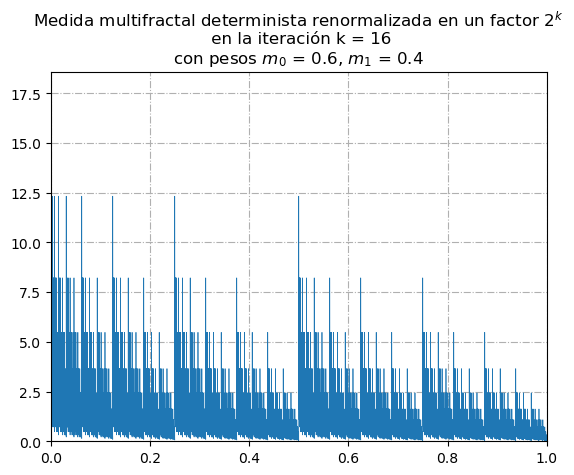

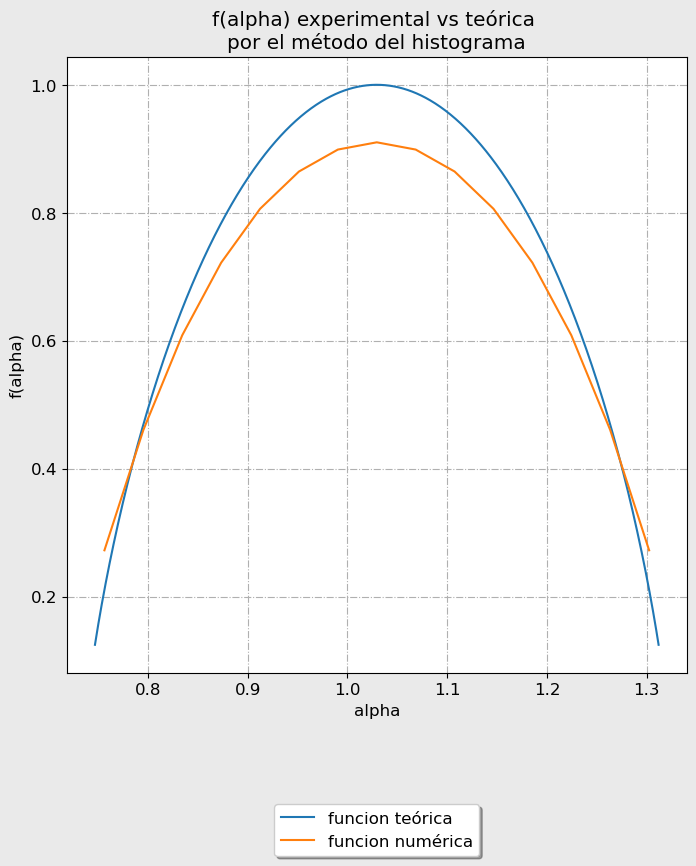

Los valores alpha min y alpha max son respectivamente: 0.7369655941662062, 1.3219280948873622. Que como vemos coinciden con los valores experimentales. 
 El máximo es 0.9101149622072042 y los alphas experimentales son 0.7174668441421677 y 1.3024293448633237


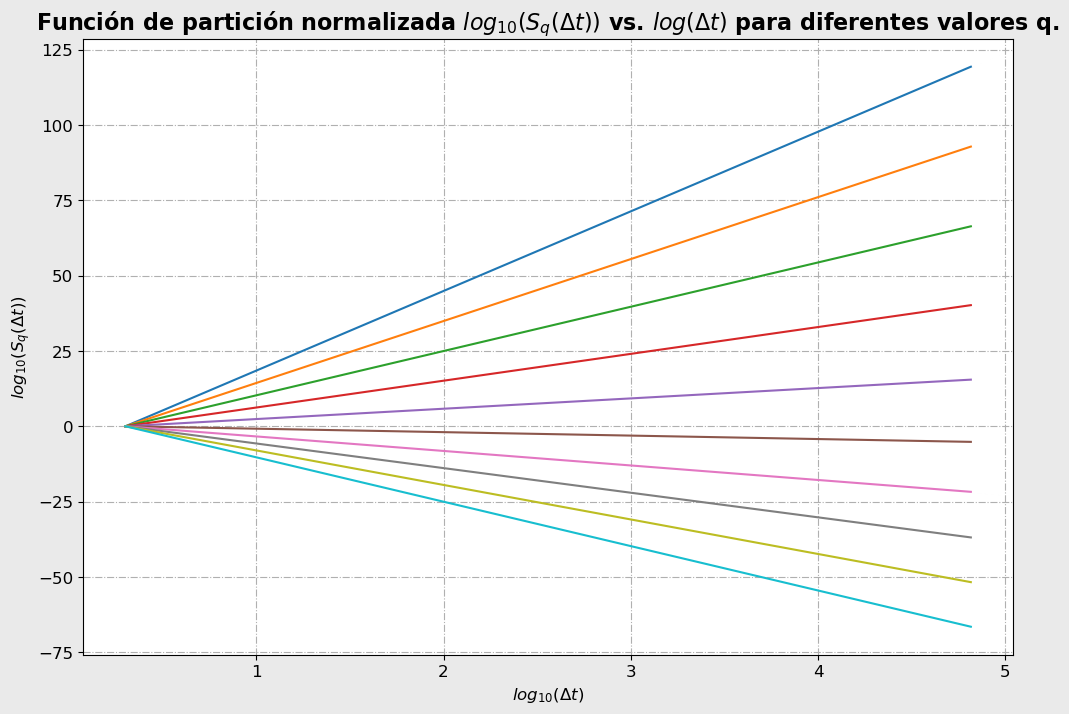

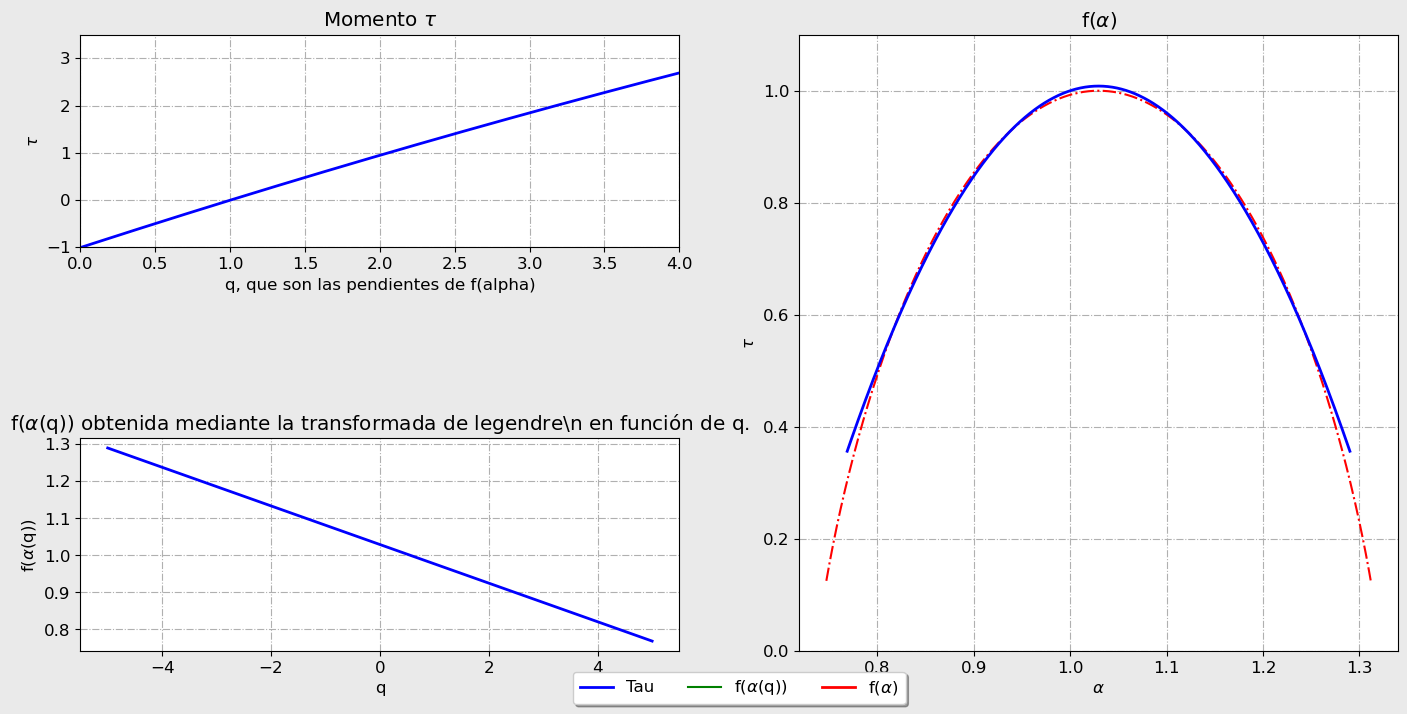

Los valores para el ajuste a una función (K/np.sqrt(x))**W son K = 1.236020790799226 y W = 1.369988163660635, con los respectivos errores del ajuste: [0.01854061 0.02387296]


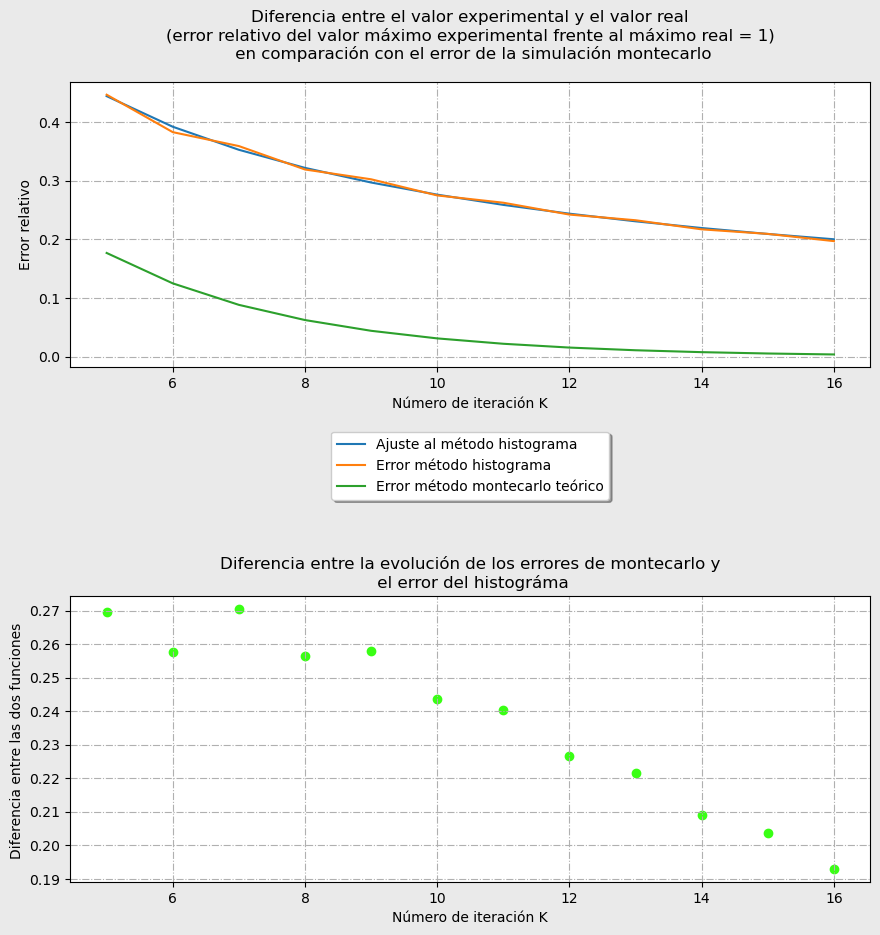

In [5]:
multifractal_measure_det(16,  0.6, 0.4, graf1 = True,test0 = True, test1 = True, test2 = True, test3 = True)

# Medida binomial aleatoria:

In [6]:
def multifractal_measure_rand(kmax, b = 2, m = 5, coef = True, graf1 = False):
    
    """
    Generates a multiplicative cascade for a random measure. This is the most
    general method constructed until now and it is not based in taking advantage
    of the properties of the dyadic intervals. For the dyadic intervals we must
    follow the instructions given in Mandelbrot's paper " Multifractal Measures ".
    
    Parameters:

    kmax = Number of iterations for the multiplicative cascade

    b = number of splits in every iteration (= 2 binomial, = 3 trinomial...)
    ADVERTENCIA: El código todavía no está preparado todavía para b > 2. 

    m = number of points in every interval.

    coef =  Returns a 2-dimensional list with the outputs of the multrifactal
            measure for each k-iterative process and for each interval in that
            k-iterative process. Basically were are defining the image set of the
            function \mu. Notice that this function is a random variable 
            because we don´t now how the weights m0,m1 are distributed along [0,1].

    graf1 = Returns the renormalized (*2^-k) graf of the multifractal measure at kmax. 
            Notice that renormalized graf is the actual density measure. 
    """

    """
    Empezamos definiendo la lista general de variables aleatorias que nos van a ir 
    saliendo en forma de cascada hasta la iteración k. Si queremos trabajar con medidas
    con b > 2 y distribuciones probabilísticas concretas (yo aquí he sugerido la 
    distribución de la función random.random()) lo tenemos que modificar aquí.

    Esta modificación puede ser fundamental para el resultado. Depende de cómo se defina
    la variable aleatoria M_beta (y por tanto de las dstribuciones de probabilidad de 
    m00 y m11) pueden generar significativos cambios en la función densidad de medida. 

    """
    if b == 2:
        lista_general = [] 
        for k in range(kmax):
            lista_coeficientes = []
            for _ in range(b**k):
                m00 = random.random()
                m11 = random.random()
                lista_coeficientes.append(np.array([m00,m11]))
            lista_general.append(lista_coeficientes)



    for i in range(len(lista_general) - 1):
        lista_general[i] = [item for sublist in lista_general[i] for item in sublist]
        for j in range(len(lista_general[i])):
            a = lista_general[i][j]* lista_general[i + 1][j]
            lista_general[i + 1][j] = a
    lista_general[-1] = [item for sublist in lista_general[-1] for item in sublist]

    # Normalizamos calulando la integral de riemann. Como estamos en un caso discreto lo único que se 
    # debe hacer es el sumatorio de riemann, sabiendo que los intervalos tienen l = 2^{-k +1} y aprovechando
    # las propiedades de los objetos ndarrays:

    constante_norm = np.sum(np.array(lista_general[-1])*2**(-(kmax + 1)))

    # Multiplicamos todos los valores imagen de la última iteración de la medida por la constante:
    lista_general[-1]/= constante_norm
    lista_general[-1].tolist()
    

    # Graficamos los resultados:

    if graf1:
        coef = False
        intervalos = [np.linspace(i*b**(-kmax), (i+1)*b**(-kmax), m) for i in range(b**kmax)]
        output = [2**(kmax + 1)*coef* np.ones(m) for coef in lista_general[-1]]
        x = np.array([item for sublist in intervalos for item in sublist])
        y = np.array([item for sublist in output for item in sublist])
        
        fig, ax = plt.subplots(figsize=(40,10))
        ax.plot(x, y, linewidth=0.8)
        #ax.set_title(f'Iteración {kmax}')  # use 'set_title' instead of 'title'
        ax.set_xlim([0, 1])  # use square brackets to set limits
        ax.set_ylim([0, np.amax(y) + 0.1])
        ax.tick_params(axis='both', which='major', labelsize=18)
        ax.grid(True)  
        plt.title(f'Iteración {kmax}')
        plt.show()


    if coef:
        return lista_general

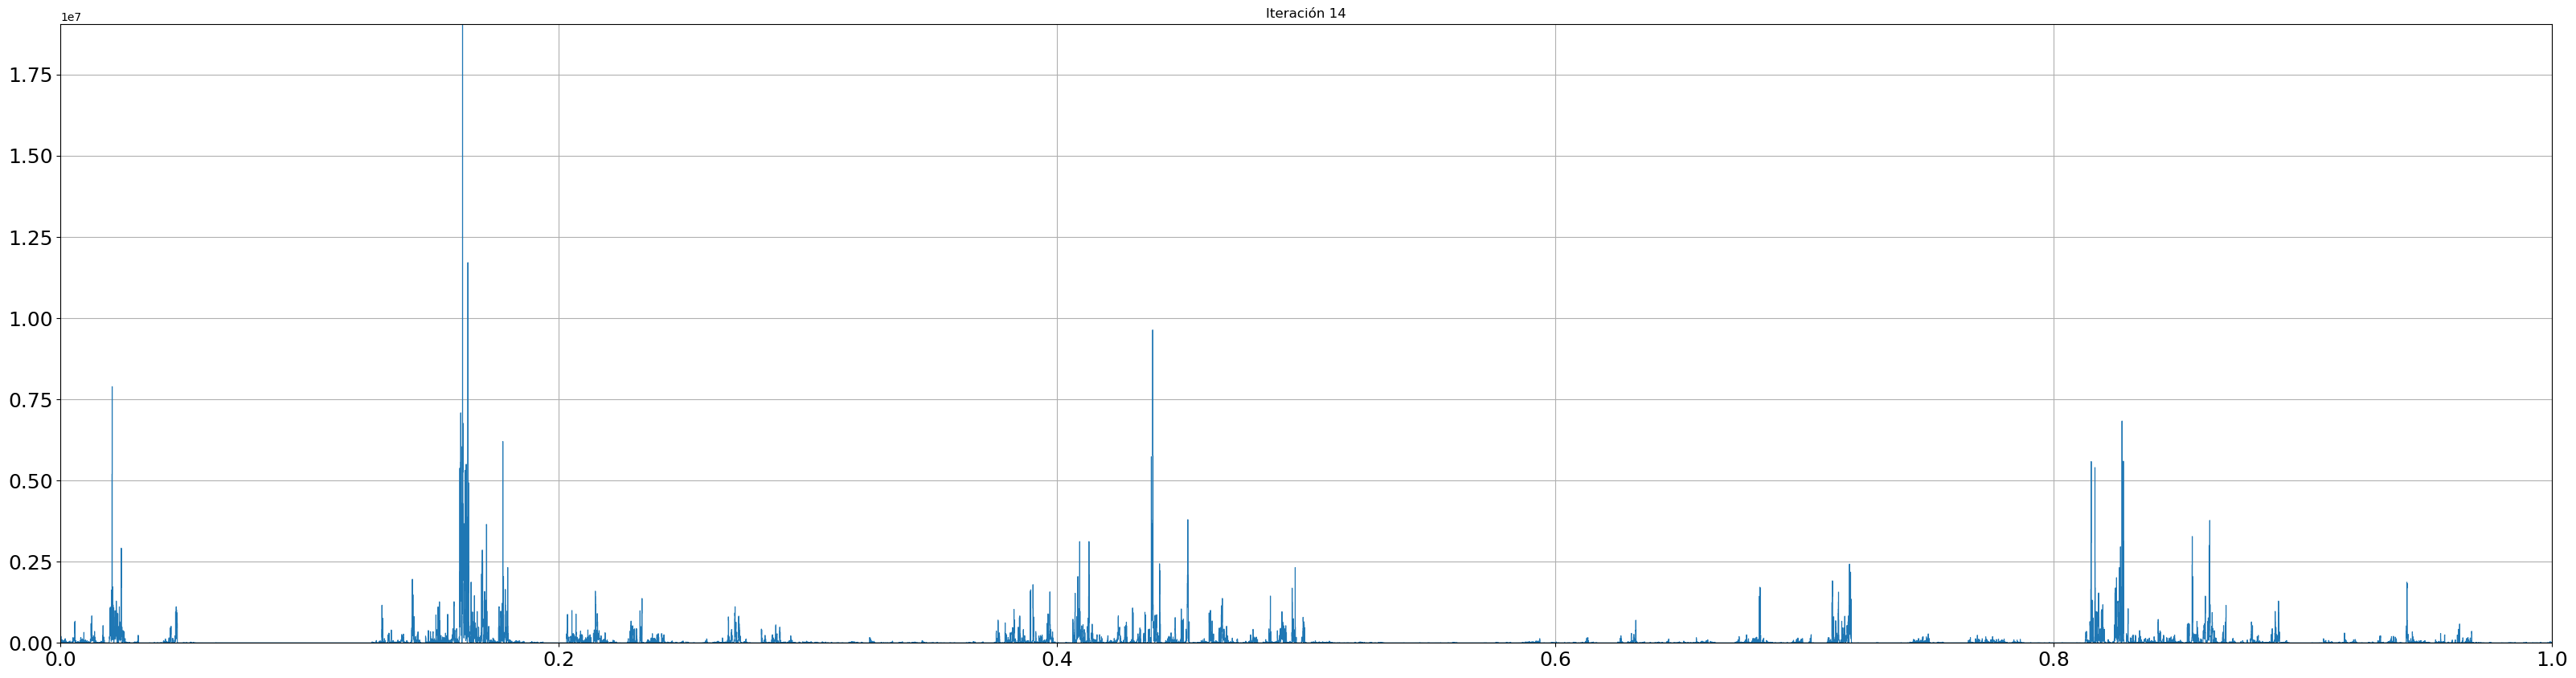

In [7]:
multifractal_measure_rand(14, graf1=True)

# Simulación MMAR

- En este documento se procede a hacer una simulación MMAR:

- Gráficas de visualización del histórico:
1. Se graficará el precio del activo. 
2. Se graficará X(t).
3. Se graficarán los incrementos diarios del activo normalizados

- Gráficas con las que se extrae las características de multifractalidad:
4. Se graficarán las funciones de partición.
5. Se graficarán los estimadores de la función de escala y el espectro de multifractalidad. 
6. Se graficará la medida multifractal con los los datos obtenidos de H, $\lambda$ y $\sigma$.

- Gráficas de la simulación Monte Carlo:
7. Se graficarán los X(t) y $\theta(t)$ simulados.
8. Se graficarán las densidades de probabilidad para cualquier variable aleatoria. 



In [3]:
class MMAR():

    def __init__(self, df, tiempo, precio, a = 0, b = 5, npuntos = 20, deltas = np.array([x for x in range(1, 1000)]), kmax = 13):
        """
        tiempo = String. Aquí tengo que meter el nombre de la columna que mide el intervalo temporal
        precio = String. Aquí tengo que meter el nombre de la columa que mide el precio del activo
        
        Esto está hecho para que de un mismo archivo Excel se puedan importar varios precios a la vez
        indicando en todo momento cómo se va a hacer mediante el excel. 

        Vamos a trabajar con objetos nd.array porque estoy más familiarizado con ellos. 

        self.df = nos muestra el dataframe entero del que se ha instanciado el objeto
        self.date = nd.array con los valores temporales en fecha
        self.days = nd.array con los valores temporales en días
        self.Price = nd.array con los valores del precio
        self.X_t = nd.array con los valores de X(t)
        self.intervalo = nd.array con los valores en los que podemos dividir el intervalo en subintervalos exactos. 
        """




        self.df = df
        self.tiempo = tiempo # Nombre de la columna temporal
        self.precio = precio # Nombre de la columna de precios, es interesante en excell llamarla "Lockheed Martin Closing Price"
        self.a = a
        self.b = b
        self.npuntos = npuntos
        self.deltas = deltas
        self.kmax = kmax
        self.date = df[tiempo].to_numpy()
        self.days = np.array([x for x in range(len(self.date))])
        self.Price = df[precio].to_numpy()
        self.X_t = np.log(self.Price) - np.log(self.Price[0])
        self.variacionprecios = self.graf_Price_change(deltat = 1, result = True, graf = False)
        self.partition = self.Partition_functions(graf1 = False, resultado = True)
        self.tau = self.tauandalpha(graf = False, resultados = True)[0]
        self.falpha = self.tauandalpha(graf = False ,resultados = True)[1]
        self.derivada = self.tauandalpha(graf = False ,resultados = True)[2]
        self.h1 = self.Hurst(graf = False)
        self.posicion_max = np.argmax(self.falpha)
        self.alpha0 = self.derivada[self.posicion_max]
        self.lambdas = self.alpha0/self.h1
        self.varianza = 2*(self.lambdas - 1)/np.log(2)


    def grafPrice(self):

        plt.style.use('default')
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.plot(self.date, self.Price, color='black', linewidth=1.5, label='Precio')

        ax.xaxis.set_major_locator(plt.MaxNLocator(6))
        date_fmt = mdates.DateFormatter('%Y-%m-%d')
        ax.xaxis.set_major_formatter(date_fmt)

        ax.grid(which='both', axis='both', linestyle='-.', linewidth=1, alpha=0.7, zorder=0, markevery=1, color='grey')
        
        #ax.set_title(f'{self.precio} Histórico de Precios', fontsize=16, fontweight='bold')
        ax.set_ylabel('Precio de Cierre ($)', fontsize=16, fontweight='bold')
        ax.set_xlabel('Tiempo (Horario de Nueva York)', fontsize=22, fontweight='bold')

        ax.legend(loc='upper left', fontsize=12)

        closing_time = '16:00:00'
        ax.tick_params(axis='both', labelsize=22)

        ax.text(self.date[-1], self.Price.max(), f'Closing Time: {closing_time} ET',
                fontsize=12, fontweight='bold', va='bottom', ha='right', color='gray',
                bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8))

        
        ax.fill_between(self.date, self.Price, where=self.Price >= 0, color="green", alpha=0.4)
        

        plt.tight_layout()
        plt.show()

    def graf_Price_change(self, deltat = 1, result = False, graf = True):

        # Calculamos la variación de precios relativa:

        # 1. Calculamos la variación de precios:
        variacion_precios1 = self.Price[deltat::deltat] - self.Price[:-deltat:deltat]
        
        # 2. Calculamos la media entre los dos precios:
        media = [(self.Price[i] + self.Price[i+1])/2 for i in range(len(self.Price) - 1)]

        # 3. Calculamos la variación de precios relativa:
        variacion_precios = [variacion_precios1[i]/media[i] for i in range(len(variacion_precios1))]

        if graf:
            fig, ax = plt.subplots(figsize=(24,5))
            ax.plot(self.days[:-1] , variacion_precios, linewidth = 0.5)

            ax.xaxis.set_major_locator(plt.MaxNLocator(6))
            date_fmt = mdates.DateFormatter('%Y-%m-%d')
            ax.xaxis.set_major_formatter(date_fmt)


            ax.grid(which='both', axis='both', linestyle='-.', linewidth=1, alpha=0.7, zorder=0, markevery=1, color='grey')
            

            ax.set_title(f'{self.precio} Histórico de Precios', fontsize=16, fontweight='bold')
            ax.set_ylabel('Variación de precios (relativa) ($)', fontsize=12, fontweight='bold')
            ax.set_xlabel('Tiempo (Horario de Nueva York)', fontsize=12, fontweight='bold')

            ax.legend(loc='upper left', fontsize=12)

            
            

            plt.tight_layout()
            plt.show()

        if result:
            return variacion_precios1

    
    def grafX_t(self):
        plt.style.use('default')
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.plot(self.date, self.X_t, color='black', linewidth=1.5, label='Price')

        ax.xaxis.set_major_locator(plt.MaxNLocator(6))
        date_fmt = mdates.DateFormatter('%Y-%m-%d')
        ax.xaxis.set_major_formatter(date_fmt)


        ax.grid(which='both', axis='both', linestyle='-.', linewidth=1, alpha=0.7, 
                zorder=0, markevery=1, color='grey')
        

        ax.set_title(f'{self.precio} Histórico de Precios', fontsize=16, fontweight='bold')
        ax.set_ylabel('X_t ($)', fontsize=12, fontweight='bold')
        ax.set_xlabel('Tiempo (Horario de Nueva York)', fontsize=12, fontweight='bold')

        ax.legend(loc='upper left', fontsize=12)

        closing_time = '16:00:00'
        ax.text(self.date[-1], self.X_t.max(), f'Closing Time: {closing_time} ET',
                fontsize=12, fontweight='bold', va='bottom', ha='right', color='gray',
                bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8))


        fig.set_facecolor('#EAEAEA')

        ax.fill_between(self.date, self.X_t, where=self.X_t >= 0, color="green", alpha=0.4)
        ax.fill_between(self.date, self.X_t, where=self.X_t < 0, color="red", alpha=0.4)

        plt.tight_layout()
        plt.show()



    def Partition_functions(self, alpha = 0.05, graf1 = True, resultado = False):

        """
        alpha = nivel de significancia
        qs = list. Son los momentos q que queremos calcular
        deltas = list. son los intervalos temporales que queremos analizar.
        a,b,c = limites y paso de las qs que queremos calcular. 
        """
        

        a = self.a
        b = self.b 
        npuntos = self.npuntos
        deltas = self.deltas
        ldeltas = len(deltas) # Serán los números de puntos que tenga cada "recta" de partición para distintos momentos. 
        mdeltas = np.mean(deltas)
        vardeltas = np.var(deltas)
        qs = np.linspace(a, b, npuntos)

        # Calculamos las funciones de partición, calculamos una para cada deltat y cada q, así, cada punto de la gráfica que representemos
        # será una función de partición concreta, una recta serán ldeltas funciones de paricion distintas asociadas a un mismo 1
        # acto seguido llevamos a cabo la regresión OLS.

        # Otra forma sería generar una matriz donde cada fila es para una q y cada columna es un deltat. Si queremos hallar esto pues transponemos. 

        # La lista partition_functions tiene subsilistas, cada elemento de una de esas sublistas es una función de partición para un delta t determinado
        # y un q determinado, por lo que estamos ploteando muchas funciones de partición y las agrupamos por q's. Una vez agrupados estudiamos la
        # media mediante OLS, porque es la condición de la esperanza matemática.

        partition_functions = [[np.sum((abs(self.X_t[deltat::deltat] - self.X_t[:-deltat:deltat]))**q) for deltat in deltas] for q in qs]
        adjustment_part_functions = [np.polyfit(np.log10(deltas), np.log10(partition_functions[i]/partition_functions[i][0]), 1) for i in range(npuntos)]
        coeficiente_normalizador = [adjustment_part_functions[i][1] for i in range(npuntos)]

        # Para calcular el intervalo de confianza (que para nosotros va a ser el error) se hará utilziando el método de la pg 55
        # del T7 de estadística y análisis de datos. Hallamos por tanto los intervalos de confianza para el valor medio.
        # 1. Calculamos las varianzas residuales (cuidado que hay que trabajar con los logaritmos):

        srs = [(np.sum((np.log10(partition_functions[i]/partition_functions[i][0]) - np.poly1d(adjustment_part_functions[i])(np.log10(deltas)))**2)/(ldeltas - 2))**(0.5) for i in range(npuntos)]

        # 2. Calculamos los intervalos de confianza sobre la estimación de la media, en este caso el conjunto dominio es deltas.

        intervalos_conf = [[t.ppf(alpha/2, ldeltas - 2)*srs[i]*np.sqrt(1/ldeltas + (deltas[j] -  mdeltas)**2/((ldeltas - 1)*vardeltas)) for j in range(ldeltas)] for i in range(npuntos)]

        # 3. Con estos datos podemos calcular los intervalos de confianza de la ordenada en el origen y la pendiente. Nos interesa
        # conocer este intervalo porque tauq es la pendiente de la regresión, por lo que el error asociado a tau es justamente ese:

        intervalos_conf_ordenada = [t.ppf(alpha/2, ldeltas - 2)*srs[i]*np.sqrt(1/ldeltas + (mdeltas)**2/((ldeltas - 1)*vardeltas)) for i in range(npuntos)]
        intervalos_conf_pendiente = [t.ppf(alpha/2, ldeltas - 2)*srs[i]/(np.sqrt(ldeltas - 1)*vardeltas) for i in range(npuntos)]

        # 4. Hacemos una prueba de correlación (equivalente al cor.test) en R (toda la teoría en los apuntes de estadística). La primera lista
        # tendrá los valores de las correlaciones y la segunda los p-value:

        corrtest1 = [stats.pearsonr(np.log10(deltas), np.log10(partition_functions[i]/partition_functions[i][0]))[0] for i in range(npuntos)]
        corrtest2 = np.array([stats.pearsonr(np.log10(deltas), np.log10(partition_functions[i]/partition_functions[i][0]))[1] for i in range(npuntos)])
        qslim = qs[corrtest2 <= alpha]

        
        if graf1:
            # Los valores de corrtest2 son el p-value. El p-value no es más que la probabilidad de que la variable aleatoria (estimador estadístico)
            # obtenga un valor más extremal que el obtenido en el estimador en caso de confirmarse la hipótesis nula (en este caso la hipótesis nula
            # es que la correlación sea 0). Fijamos el intervalo de confinaza al 95% (viene especificado por la variable alpha de este método).
            # 1. Calculamos la lista de los q tal que su p-value es mayor que el nivel de significancia:
            
            fig, ax = plt.subplots(figsize=(12, 8))
            
            
            colors = ["#FF0000", "#00FF00", "#0000FF", "#000000", "#FF00FF", "#00FFFF", "#FFA500", "#800080", "#008000", "#800000", "#008080", "#000080", "#FFFFE0", "#FFD700", "#00FF7F", "#FF4500", "#9400D3", "#808000", "#FF1493", "#6A5ACD"]

            for i, q in enumerate(qslim):
                ax.plot(np.log10(deltas), np.poly1d([q/2-1,0])(np.log10(deltas)), linestyle="-.", color = "black")
                ax.plot(np.log10(deltas), np.log10(partition_functions[i]/partition_functions[i][0]), 
                        label=f"q = {q:.2f}", color=colors[i % len(colors)])
                ax.plot(np.log10(deltas), np.poly1d(adjustment_part_functions[i])(np.log10(deltas)), color=colors[i % len(colors)])    
                ax.fill_between(np.log10(deltas), np.poly1d(adjustment_part_functions[i])(np.log10(deltas)) - intervalos_conf[i],  
                                np.poly1d(adjustment_part_functions[i])(np.log10(deltas)) + intervalos_conf[i], 
                                color=colors[i % len(colors)], alpha = 0.4)
        
            ax.grid(which='both', axis='both', linestyle='-.', linewidth=1, alpha=0.7, zorder=0, markevery=1, color='grey')

            # Añadimos títulos 
            #ax.set_title(r"Función de partición normalizada $log_{10}(S_q(\Delta t))$ vs. $log(\Delta t)$ para diferentes valores q." +"\n Curvas ajustadas por OLS:", fontsize=16, fontweight='bold')
            ax.set_ylabel(r"$log_{10}(\hat{S}_q(\Delta t))$", fontsize=15, fontweight='bold')
            ax.set_xlabel(r"$log_{10}(\Delta t)$", fontsize=15, fontweight='bold')
            #ax.set_ylim(-3.5,2.5)

            # Añadimos leyenda:
            ax.legend(loc='best', fancybox=True, shadow=True, ncol=5, fontsize=12)
            #ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), 
            #fancybox=True, shadow=True, ncol=5, fontsize=12)
            

            plt.tight_layout()

            plt.subplots_adjust(bottom=0.2)
            
            plt.show()




            # Gragicamos las funciones de partición sin normalizar. 

            fig, ax = plt.subplots(figsize=(12, 8))
            
            
            colors = ["#FF0000", "#00FF00", "#0000FF", "#000000", "#FF00FF", "#00FFFF", "#FFA500", "#800080", "#008000", "#800000", "#008080", "#000080", "#FFFFE0", "#FFD700", "#00FF7F", "#FF4500", "#9400D3", "#808000", "#FF1493", "#6A5ACD"]

            for i, q in enumerate(qslim):
                ax.plot(np.log10(deltas), np.log10(partition_functions[i]), label=f"q = {q:.2f}", color=colors[i % len(colors)])        
                 # En las gráficas se observan mayor concentración de puntos cuanto mayor valor de x, es normal porque la distribución es homogénea y
                # al estar en escala logaritmica se aglomeran los puntos en los valores de más a la derecha:
                 
        
            ax.grid(which='both', axis='both', linestyle='-.', linewidth=1, alpha=0.7, zorder=0, markevery=1, color='grey')

            # Añadimos títulos 
            ax.set_title(r"Función de partición normalizada $log_{10}(S_q(\Delta t))$ vs. $log(\Delta t)$ para diferentes valores q." +"\n Curvas ajustadas por OLS:", fontsize=16, fontweight='bold')
            ax.set_ylabel(r"$log_{10}(S_q(\Delta t))$", fontsize=12, fontweight='bold')
            ax.set_xlabel(r"$log_{10}(\Delta t)$", fontsize=12, fontweight='bold')
            ax.set_ylim(-3.5,5)

            # Añadimos leyenda:
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
            fancybox=True, shadow=True, ncol=5, fontsize=12)
            
            fig.set_facecolor('#EAEAEA')

            plt.tight_layout()

            plt.subplots_adjust(bottom=0.2)
            
            plt.show()

        
            ax.grid(which='both', axis='both', linestyle='-.', linewidth=1, alpha=0.7, zorder=0, markevery=1, color='grey')

            # Añadimos títulos 

            ax.set_ylabel(r"$\frac{log_{10}(S_q(\Delta t))}{log_{10}(\Delta t)}$", fontsize=18, fontweight='bold')
            ax.set_xlabel(r"$log_{10}(\Delta t)$", fontsize=18, fontweight='bold')
            ax.set_ylim(-3.5,5)

            # Añadimos leyenda:
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
            fancybox=True, shadow=True, ncol=5, fontsize=12)
            
            fig.set_facecolor('#EAEAEA')

            plt.tight_layout()

            plt.subplots_adjust(bottom=0.2)
            
            plt.show()

        if resultado: 
            print(f"Los valores de los ajustes (a,m respectivame) son {adjustment_part_functions}" +
                  f"\nLos errores asociados a la ordenada (término independiente) vienen dados por {intervalos_conf_ordenada}")
            
            # print(f"Las magnitudes de los intervalos de confianza son: {intervalos_conf}")

            print(f"La hipótesis nula se descarta hasta el valor q = {qslim[-1]}.")
            print(f"El estimador coeficiente de correlación para cada q tiene como valores: {corrtest1}" +
                  f"\nMientras que los p-values asociados al estimador son: {corrtest2}")
            # Instanciamos los objetos fig, ax de la clase subplots.
            return partition_functions, adjustment_part_functions 
            






    def tauandalpha(self, alpha = 0.05, graf = True, resultados = False):
        plt.style.use('default')
        a = self.a
        b = self.b 
        npuntos = self.npuntos
        deltas = self.deltas
        ldeltas = len(deltas) # Serán los números de puntos que tenga cada "recta" de partición para distintos momentos. 
        mdeltas = np.mean(deltas)
        vardeltas = np.var(deltas)
        qs = np.linspace(a, b, npuntos)

        # Calculamos las funciones de partición:

        partition_functions = [[np.sum((abs(self.X_t[deltat::deltat] - self.X_t[:-deltat:deltat]))**q) for deltat in deltas] for q in qs]
        adjustment_part_functions = [np.polyfit(np.log10(deltas), np.log10(partition_functions[i]/partition_functions[i][0]), 1) for i in range(npuntos)]
        coeficiente_normalizador = [adjustment_part_functions[i][1] for i in range(npuntos)]


        # De nuevo, los intervalos de confianza:
        srs = [(np.sum((np.log10(partition_functions[i]) - np.poly1d(adjustment_part_functions[i])(np.log10(deltas)))**2)/(ldeltas - 2))**(0.5) for i in range(npuntos)]
        intervalos_conf = [[t.ppf(alpha/2, ldeltas - 2)*srs[i]*np.sqrt(1/ldeltas + (deltas[j] -  mdeltas)**2/((ldeltas - 1)*vardeltas)) for j in range(ldeltas)] for i in range(npuntos)]
        intervalos_conf_ordenada = [t.ppf(alpha/2, ldeltas - 2)*srs[i]*np.sqrt(1/ldeltas + (mdeltas)**2/((ldeltas - 1)*vardeltas)) for i in range(npuntos)]
        intervalos_conf_pendiente = [t.ppf(alpha/2, ldeltas - 2)*srs[i]/(np.sqrt(ldeltas - 1)*vardeltas) for i in range(npuntos)]

        
        # Calculamos tau como en el caso de la medida binomial (mirar Simulacion_sucio1 para entender mejor todo, que lo tengo bien redactado)
        tau = [sublistasajustes[0] for sublistasajustes in adjustment_part_functions]
        h = (b-a)/npuntos # distancia de puntos que tenemos en qs, como en el caso binomial
        # Vamos a calcular la deerivada mediante splines:
        intervalo1 = np.linspace(qs[0], qs[-1], 1000)
        spline = UnivariateSpline(qs, tau)
        derivada1 = spline.derivative()(intervalo1)
        legendre1 = intervalo1*derivada1 - spline(intervalo1)

        # Calculamos los intervalos de confianza para la función de escala \tau:

        # 1. Hallamos todas las taus posibles (todas las lineas verticales y no el promedio de ellas), 
        # para ello hallamos la pendiente para cada una de las tau presuponiendo que nacen desde 0 
        # (esta presuposición es correcta porque se cumple la hipótesis nula y los intervalos de confianza
        # de las curvas ajustadas por OLS contienen a 0), (f(x) - f(0))/(x - 0), que se manifiesta como:

        tausposibles = [[np.log10(partition_functions[i][j]/partition_functions[i][0])/np.log10(deltas[j]) for i in range(npuntos)] for j in range(1, ldeltas)] # Hacemos que vaya desde 1 porque ldeltas[0] = 1 y log(1) = 0 y si dividimos tenemos problemas.
        splinesposibles = [UnivariateSpline(qs, taus) for taus in tausposibles]
        lengendreposbiles = [intervalo1*splines.derivative()(intervalo1) - splines(intervalo1) for splines in splinesposibles]


        if graf:
            
    
            # Ploteamos:
            
            # plt.style.use('dark_background')
            figure = plt.figure(figsize=(17, 8))

            # Los intervalos de confianza de la pendiente son tan pequeños que no se visualizan.
            ax1 = plt.subplot2grid((2, 4), (0, 0), colspan=2)
            
            for i in range(ldeltas - 1):
                ax1.plot(intervalo1, splinesposibles[i](intervalo1), alpha = 0.1, color = "grey")
            
            ax1.plot(intervalo1, spline(intervalo1), lw=2, color='blue')
            ax1.fill_between(qs, np.array(tau) - np.array(intervalos_conf_pendiente), np.array(tau) + np.array(intervalos_conf_pendiente), color = "red")
            # ax1.fill_between(qs, np.array(tau) - np.array(intervalos_conf_pendiente), np.array(tau) + np.array(intervalos_conf_pendiente), color = "red")
            ax1.set_title(r"a)", fontsize=18)
            ax1.set_xlabel("q", fontsize=18)
            ax1.set_ylabel(r"$\hat{\tau}$", fontsize=18)
            ax1.grid(True, linestyle='dashdot')
            ax1.set_ylim(-1,1)
            ax1.set_xlim(0,qs[-1])


            ax2 = plt.subplot2grid((2, 4), (1, 0), colspan=2)
            
            for i in range(ldeltas - 1):
                ax2.plot(intervalo1, splinesposibles[i].derivative()(intervalo1), alpha = 0.1, color = "grey")
            
            ax2.plot(intervalo1, derivada1, lw=2, color = "blue")
            ax2.set_title(r"c)", fontsize=18)
            ax2.set_xlabel("q", fontsize=18)
            ax2.set_ylabel(r'$\hat{f}$($\alpha$(q))', fontsize=18)

            #ax2.set_xlim(0,qs[-1])
            ax2.grid(True, linestyle='dashdot')

            ax3 = plt.subplot2grid((2, 4), (0, 2), rowspan=2, colspan=2)
            
            for i in range(ldeltas - 1):
                ax3.plot(splinesposibles[i].derivative()(intervalo1), lengendreposbiles[i], alpha = 0.1, color = "grey")
            
            ax3.plot(derivada1, legendre1, lw=2, color='red')
            ax3.set_ylim(0.5,1.05)
            ax3.set_title(r"b)", fontsize=18)
            ax3.set_xlabel(r"$\alpha$", fontsize=18)
            ax3.set_ylabel(r'$\hat{f}(\alpha)$', fontsize=18)
            ax3.grid(True, linestyle='dashdot')


            custom_lines = [Line2D([0], [0], color='blue', lw=2),
                            Line2D([0], [0], color='green', markerfacecolor='green', markersize=5), # marker='o',
                            Line2D([0], [0], color='red', lw=2)]
            custom_labels = ['Tau', r'f($\alpha$(q))', r'f($\alpha$)']

            #legend = plt.legend(custom_lines, custom_labels, loc='lower center', bbox_to_anchor=(-0.1, -0.1), fancybox=True, shadow=True, ncol=3)
            ax1.tick_params(axis='both', which='major', labelsize=17)
            ax2.tick_params(axis='both', which='major', labelsize=17)
            ax3.tick_params(axis='both', which='major', labelsize=17)
            plt.subplots_adjust(wspace=0.5, hspace=0.9)
            plt.show()
            

        if resultados:
            print(f"Los intervalos de confinaza son $\pm${intervalos_conf_pendiente}")
            return spline(intervalo1), legendre1, derivada1




    def Hurst(self, graf = False):

        # Procedemos a calcular el coeficiente Hurst. 

        a = self.a
        b = self.b 
        npuntos = self.npuntos
        deltas = self.deltas
        qs = np.linspace(a, b, npuntos)
        # Calculamos las funciones de particion y sus regresiones lineales OLS:
        partition_functions = [[np.sum((abs(self.X_t[deltat::deltat] - self.X_t[:-deltat:deltat]))**q) for deltat in deltas] for q in qs]
        adjustment_part_functions = [np.polyfit(np.log10(deltas), np.log10(partition_functions[i]), 1) for i in range(len(qs))]

        # Calculamos tau como en el caso de la medida binomial determinista:
        tau = [sublistasajustes[0] for sublistasajustes in adjustment_part_functions]
        h = (b-a)/npuntos 
        intervalo1 = np.linspace(qs[0], qs[-1], 1000)
        spline = UnivariateSpline(qs, tau)
        derivada = spline.derivative()(intervalo1)
        legendre = intervalo1*derivada - spline(intervalo1)



        if graf:
            plt.style.use('default')
            # Comparamos con el polinomio original visualmente:
            figure = plt.figure(figsize=(12, 6))

            ax1 = plt.subplot(2, 2, 1)
            ax1.plot(qs, tau, lw=2, color='r',ls = "-.")
            ax1.plot(qs, p(qs), lw=2, color='green')
            ax1.set_title("Momento tau_p")
            ax1.set_xlabel("q, que son las pendientes de f(alpha)")
            ax1.set_ylabel("Tau")
            ax1.grid(True, linestyle='dashdot')

            plt.show()


        # Hallamos la unica solución definida en el intervalo en el que 
        # hemos interpolado el spline (se ve en la gráfica que tau solo
        # tiene una raiz en ese intervalo):
        sol1 = spline.roots()[0]

        # Inveritmos los coeficiente Hurst será:
        h1 = 1/sol1

        return h1
    


    def multifractal_measure_rand(self, b = 2, m = 1, masas1 = False, masas2 = True, coef = False, graf1 = False, cumsum = False):
        """
        Medida multifractal que cumple con los parámetros lambda y sigma de la distribución lognormal
        de la pagina 22 del DM/Dollar. Para mas info mirar Simulacion_sucio1:
        masas: nos muestran la forma de generar las variables aleatorias M. 
        """
        kmax = self.kmax
        # Puesto que ya hemos calculado previamente H, solo debemos calcular alpha_0, esta 
        # se define como el valor del dominio alpha donde f(alpha) alcanza el máximo, 
        # esto lo podemos encontrar mediante la función np.argmax(), que nos da la posición
        # en la lista del máximo indice:
        posicion_max = np.argmax(self.falpha)
        # Buscamos en el dominio que, debido a que estamos trabajando con la transformada de
        # legendre, se trata de las alphas, que son las derivadas de tau, es decir, sus pendientes:
        alpha0 = self.derivada[posicion_max]

        lambdas = alpha0/self.h1
        varianza = 2*(lambdas - 1)/np.log(2)

        # Generamos la medida multifractal que conserva la masa en promedio, por lo que necesitamos la omega. La omega tendrá
        # en nuestro caso una distribución normal con media centrada en aquel valor x tal que x*lambda*lambda = 1, en este caso:

        # media_omega = 1/(lambdas**2)

        # Generamos la variable aleatoria lognormal:
        def lognormal_base2(lambdas, varianza):
            # Generamos la variable aleatoria normal:
            normal_random_variable = np.random.normal(loc=lambdas, scale=np.sqrt(varianza))

            # Creamos la variable aleatoria lognormal:
            lognormal_base2var = 2 ** -normal_random_variable

            return lognormal_base2var


        # Generamos la lista de todas las variables aleatorias M_b a lo largo de la cascada:

        lista_general = [] 
        for k in range(kmax):
            lista_coeficientes = []
            for _ in range(2**k):
                if masas1:
                    masas2 = False
                    m00 = (lambda x: x / (x + (1 / x)))(2 ** -np.random.normal(lambdas, np.sqrt(varianza)))
                    m11 = 1 - m00
    
                if masas2:
                    m00 = lognormal_base2(lambdas, varianza)
                    m11 = lognormal_base2(lambdas, varianza)
                    

                lista_coeficientes.append(np.array([m00,m11]))
            lista_general.append(lista_coeficientes)

        # Multiplicamos en cascada y obtenemos la imagen para cada intervalo en la iteración k-ésima.
        # Además, en el proceso convertimos la lista en una lista bidimensional.  

        for i in range(len(lista_general) - 1):
            lista_general[i] = [item for sublist in lista_general[i] for item in sublist]
            for j in range(len(lista_general[i])):
                a = lista_general[i][j]* lista_general[i + 1][j]
                lista_general[i + 1][j] = a
        lista_general[-1] = np.array([item for sublist in lista_general[-1] for item in sublist])

        """
        # Normalizamos calulando la integral de riemann. Como estamos en un caso discreto lo único que se 
        # debe hacer es el sumatorio de riemann, sabiendo que los intervalos tienen l = 2^{-k +1} y aprovechando
        # las propiedades de los objetos ndarrays:

        constante_norm = np.sum(lista_general[-1]*2**(-(kmax + 1)))

        # Multiplicamos todos los valores imagen de la última iteración de la medida por la constante:
        lista_general[-1]/= constante_norm
        lista_general[-1].tolist()
        """

        # Procedemos a normalizar con el uso de la variable aleatoria Omega con la desviación típica de M para simplificar
        # (mirar mi cuadernito de apuntes para entender cómo derivo esta ecuación):

        media_omega = 1/(2**(-lambdas*kmax))
        omega = np.random.normal(media_omega, np.sqrt(varianza), 2**kmax)

        lista_general[-1] *= omega
        

        # Graficamos los resultados:

        if graf1:
            coef = False
            intervalos = [np.linspace(i*b**(-kmax), (i+1)*b**(-kmax), m) for i in range(b**kmax)]
            # output = [2**(kmax + 1)*coef* np.ones(m) for coef in lista_general[-1]] (para el caso sin normalizar con omega)
            output = [coef* np.ones(m) for coef in lista_general[-1]]
            x = np.array([item for sublist in intervalos for item in sublist])
            y = np.array([item for sublist in output for item in sublist])
            
            fig, ax = plt.subplots(figsize=(60,5))
            ax.plot(x, y, linewidth=0.8)
            #ax.set_title(f'Iteración {kmax}')  # use 'set_title' instead of 'title'
            ax.set_xlim([0, 1])  # use square brackets to set limits
            ax.set_ylim([0, np.amax(y) + 0.1*np.amax(y)])
            ax.tick_params(axis='both', which='major', labelsize=18)
            ax.grid(True)  # add gridlines
            plt.show()

        # Mostramos el valor de salida de cada uno de los intervalos:

        if coef:
            return lista_general, lambdas, varianza
        
        if cumsum:
            return np.cumsum(lista_general[-1])
        
    
    def simulacion(self, grafs = False, results = False):
        
        # kmax es 2^kmax número de días que queremos simular
        kmax = self.kmax

        # Calculamos el trading time normalizado
        # tradingtime = 2**kmax*self.multifractal_measure_rand(kmax, cumsum = True)
        tradingtime = self.multifractal_measure_rand(cumsum = True)
        # Normalizamos y multiplicamos para obtener el número de días.
        tradingtime =  2**kmax*(tradingtime/np.amax(tradingtime))


        # Calculamos el fractional brownian motion fbm:

        # 1. Instanciamos la clase con el objeto fbm
        fbm = fractional_brownian_motion.FractionalBrownianMotion(hurst= self.h1)
        # 2. Usamos el método _sample_fractional_brownian_motion para crear la lista con los incrementos
        # con respecto al tiempo real.
        simulacionfbm = fbm._sample_fractional_brownian_motion(2**kmax-1)

        # Calculamos los valores Xt con respecto al tiempo real:
        xtsimulados = simulacionfbm
        precio_final = self.Price[0]*np.exp(xtsimulados)

        



        if grafs:
            plt.plot(np.array([x for x in range(2**kmax)]), tradingtime)
            plt.show()

            # En la gráfica es donde se hace la composición de funciones! Mirar reflexión 
            # en simulacion_sucio1:

            plt.plot(tradingtime, precio_final )
            # Tenemos que etiquetar con los valores del tiempo real, así es como se produce
            # la deformación que buscamos!
            plt.title("Grafica con deformación")
            plt.xlabel("Tiempo real")
            plt.show()

            plt.plot([x for x in range(2**kmax)], precio_final)
            plt.title("Grafica sin deformación")
            plt.xlabel("Tiempo real")
            plt.show()

            # plt.plot(np.array([x for x in range(2**kmax - 1)]), [precio_final[i+1] - precio_final[i] for i in range(len(precio_final)-1)] )
            plt.plot(np.array([x for x in range(2**kmax - 1)]), precio_final[1:] - precio_final[:-1], lw = 0.5)
            plt.show()


            plt.plot(tradingtime, precio_final)
            # Tenemos que etiquetar con los valores del tiempo real, así es como se produce
            # la deformación que buscamos!
            plt.title("Grafica sin deformación")
            plt.xlabel("TradingTime")
            plt.show()

            
        if results:
            return tradingtime
    

    
    def simulacion2(self, n = 1000, resultado = False):
        """
        Esta es la simulación montecarlo de n curvas en contraste con la simulación de 1 curva en la 
        función anterior. 
        """
        almacen_tradingtime = []
        almacen_xt = []
        almacen_precio_final = []

        kmax = self.kmax

        for _ in range(n):
            # Hallamos el trading time sin normalizar.
            tradingtime = self.multifractal_measure_rand(cumsum = True)
            # Normalizado:
            tradingtime =  2**kmax*(tradingtime/np.amax(tradingtime))
            fbm = fractional_brownian_motion.FractionalBrownianMotion(hurst= self.h1)
            simulacionfbm = fbm._sample_fractional_brownian_motion(2**kmax-1)
            xtsimulados = simulacionfbm
            precio_final = self.Price[-1]*np.exp(xtsimulados)

            almacen_tradingtime.append(tradingtime)
            almacen_xt.append(xtsimulados)
            almacen_precio_final.append(precio_final)


        fig, ax = plt.subplots(figsize=(12, 8))
        

        for i in range(len(almacen_precio_final)):
            ax.plot(almacen_tradingtime[i], almacen_xt[i], lw=0.5, alpha=0.1)

        ax.plot(almacen_tradingtime[n//2], almacen_xt[n//2], lw=0.5, alpha=1, color='b')

        ax.set_xlabel("Tiempo real (días)", fontsize=22)
        ax.set_ylabel(r"X(t)", fontsize=22)
        # ax.set_xlim(0, 8000)
        ax.tick_params(axis='both', labelsize=22)
        ax.grid(True, linestyle='-.')
        plt.tight_layout()
        plt.show()

        fig, ax = plt.subplots(figsize=(12, 8))

        for i in range(len(almacen_tradingtime)):
            ax.plot([x for x in range(2**kmax)], almacen_tradingtime[i], lw=0.5, alpha=0.1)
        ax.plot([x for x in range(2**kmax)], almacen_tradingtime[n//2], lw=0.5, alpha=1, color='b')


        ax.set_xlabel("Tiempo real (días)", fontsize=22)
        ax.set_ylabel("Trading time (días)", fontsize=22)
        # ax.set_ylim(0, 8000)
        ax.tick_params(axis='both', labelsize=22)
        ax.grid(True, linestyle='-.')
        plt.tight_layout()
        plt.show()

        return almacen_tradingtime, almacen_precio_final, almacen_xt

    
    def analizadorprobabilidades(self, dia, almacen_tradingtime, almacen_precio_final):
        # Esta función nos analizará las probabilidades para cada output del método simulacion2.
        # n es el número de simulaciones hechas en simulacion2



        # Calculamos las funciones de densidad de probabilidad para cada tiempo, para ello calculamos la regla de laplace,
        # es decir, vamos a calcular los histogramas para cada tiempo y listo:

        # 1. Calculamos las listas para los histogramas:
        # El principal problema es que como hacemos una composición de funciones, el tiempo asignado a cada precio con un mismo
        # indice i de cada sublista no es el mismo. Dependerá de la función de transición de cada uno de ellos. Por tnato, hacemos
        # una interporlación lieal de cada uno de los pares almacen_precio_final[i] - almacen_tradingtime[i] y trabajamos siendo consecuentes
        # con la composición de funciones:

        # Hallamos los precios para el día concreto (real) siendo consecuentes con la deformación del tiempo con el trading time
        # mediante la interpolación lineal (no se si hay interpolaciones mejores). La interpolación es la mejor forma de hacer 
        # composiciones de funcinoes a nivel computacional:
        n = len(almacen_tradingtime)
        precios_serios = [np.interp(dia, almacen_tradingtime[i], almacen_precio_final[i]) for i in range(n) if np.interp(dia, almacen_tradingtime[i], almacen_precio_final[i])]
        hist, bins = np.histogram(precios_serios, bins=50, density=True)
        media = np.mean(precios_serios)
        stdd = np.std(precios_serios)


        # Generamos una gaussiana con la que comparar:
        x = np.linspace(bins[0]-1, bins[-1]+1, 10000)
        y = stats.norm.pdf(x, media, stdd)


        fig, ax = plt.subplots(figsize=(12, 8))
        ax.hist(precios_serios, bins=50, alpha=0.5, density=True, edgecolor='black', label = "Distribución real")
        ax.plot(x, y, color = 'red', linewidth = 2, label = "Distribución gaussiana (TLC)")
        textbox_text = f'Media: {media:.2f}\nDesviación estándar: {stdd:.2f}'
        ax.text(0.95, 0.95, textbox_text, transform=ax.transAxes, fontsize=22, verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', edgecolor='black', alpha=0.7))



        #ax.set_title(f'Precio en el día {dia} con media {media:.2f} y desviación {stdd:.2f}', fontsize=16)
        ax.set_xlabel(f'P({dia}) ($)', fontsize=22)
        ax.set_ylabel('Densidad de probabilidad', fontsize=22)

        ax.tick_params(axis='both', which='major', labelsize=22)

        # Agregando lineas horizontales
        ax.grid(axis='y')
        plt.legend(loc='center right', fontsize=18)
        plt.tight_layout()
        plt.show()



In [9]:
df = pd.read_csv("Lockheed.txt", delimiter='\t', header=0)

Los valores de los ajustes (a,m respectivame) son [array([-1.01743579,  0.02941039]), array([-0.81203939, -0.01560603]), array([-0.61798576, -0.05370916]), array([-0.43411014, -0.08333203]), array([-0.26063928, -0.10412283]), array([-0.09812815, -0.11526053]), array([ 0.05292546, -0.11609373]), array([ 0.19236481, -0.10649352]), array([ 0.32053131, -0.08698052]), array([ 0.43826813, -0.05863599])]
Los errores asociados a la ordenada (término independiente) vienen dados por [-0.0013889050460424172, -0.0035302723164532144, -0.005703361664293956, -0.007777401720161837, -0.009934923581575338, -0.012256148276213836, -0.014773118759593404, -0.01749546750679333, -0.02042074499169447, -0.0235376276597639]
La hipótesis nula se descarta hasta el valor q = 3.0.
El estimador coeficiente de correlación para cada q tiene como valores: [-0.9996713093846648, -0.9966813116693434, -0.985300041418549, -0.9477569222911368, -0.813034465017346, -0.39205710062547405, 0.18732075646663066, 0.5051120601092954, 

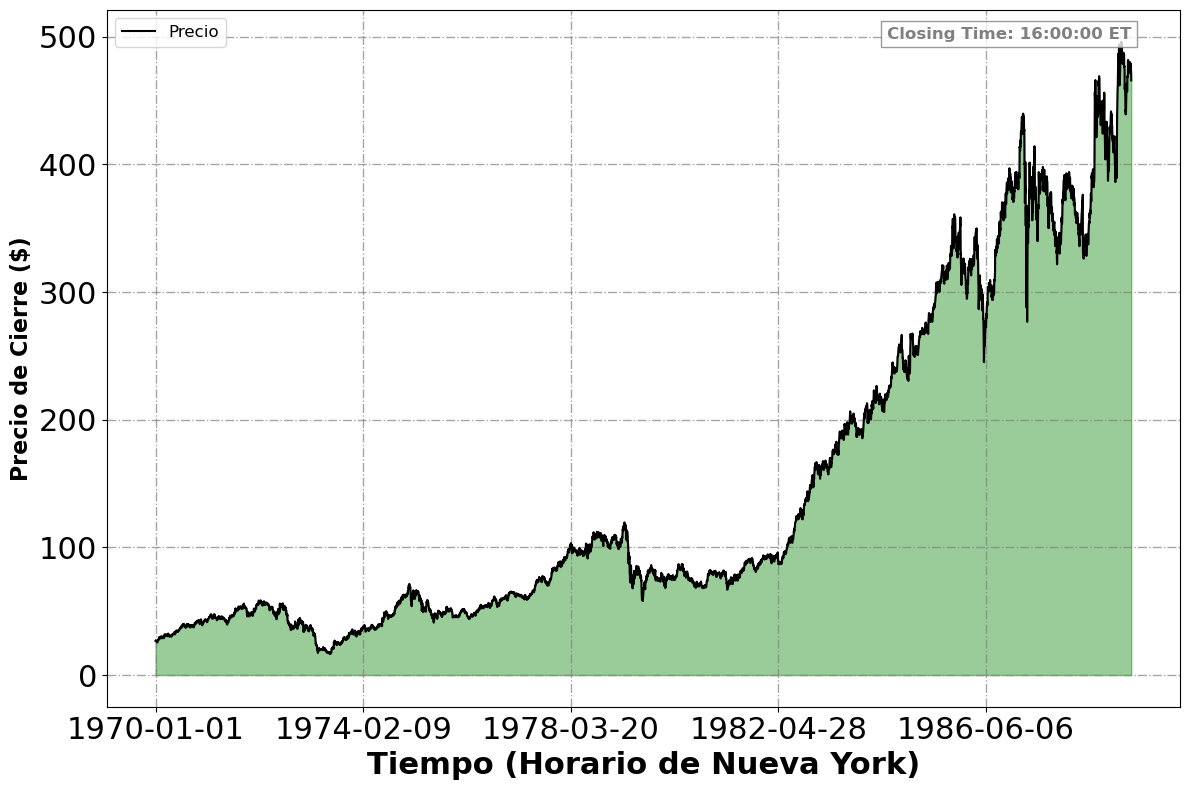

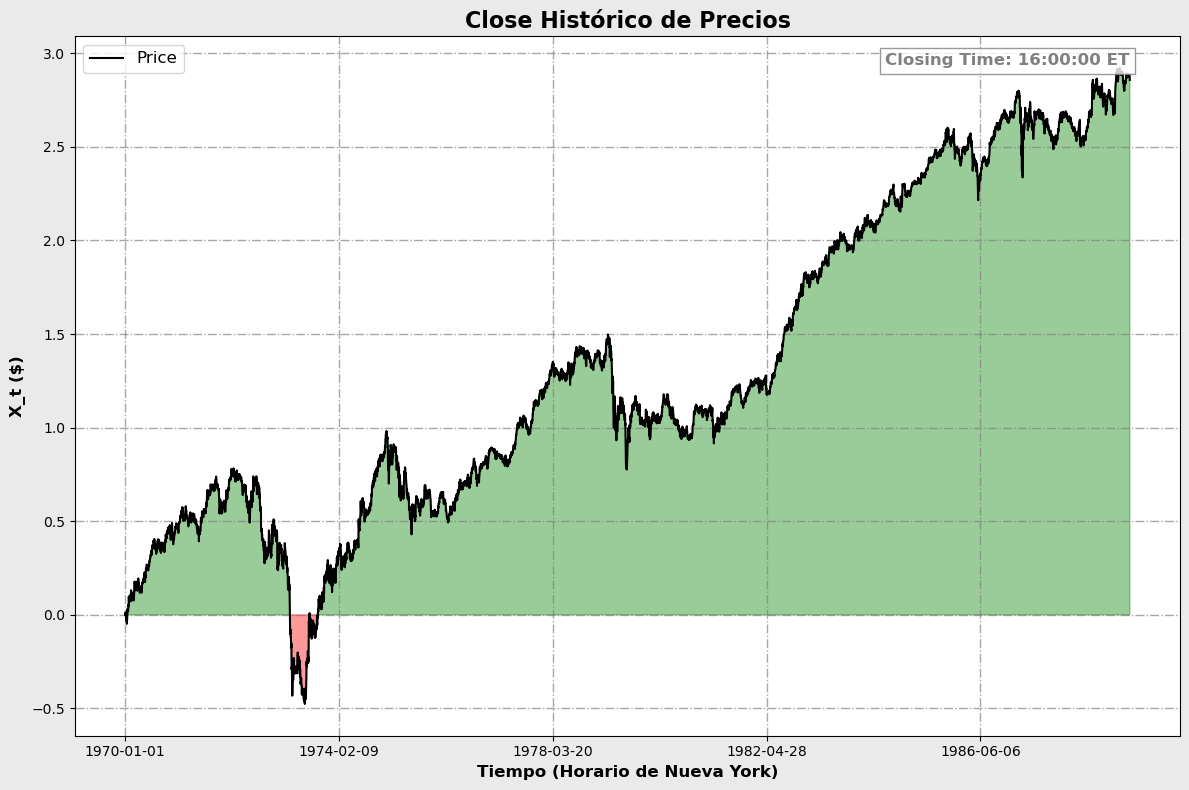

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


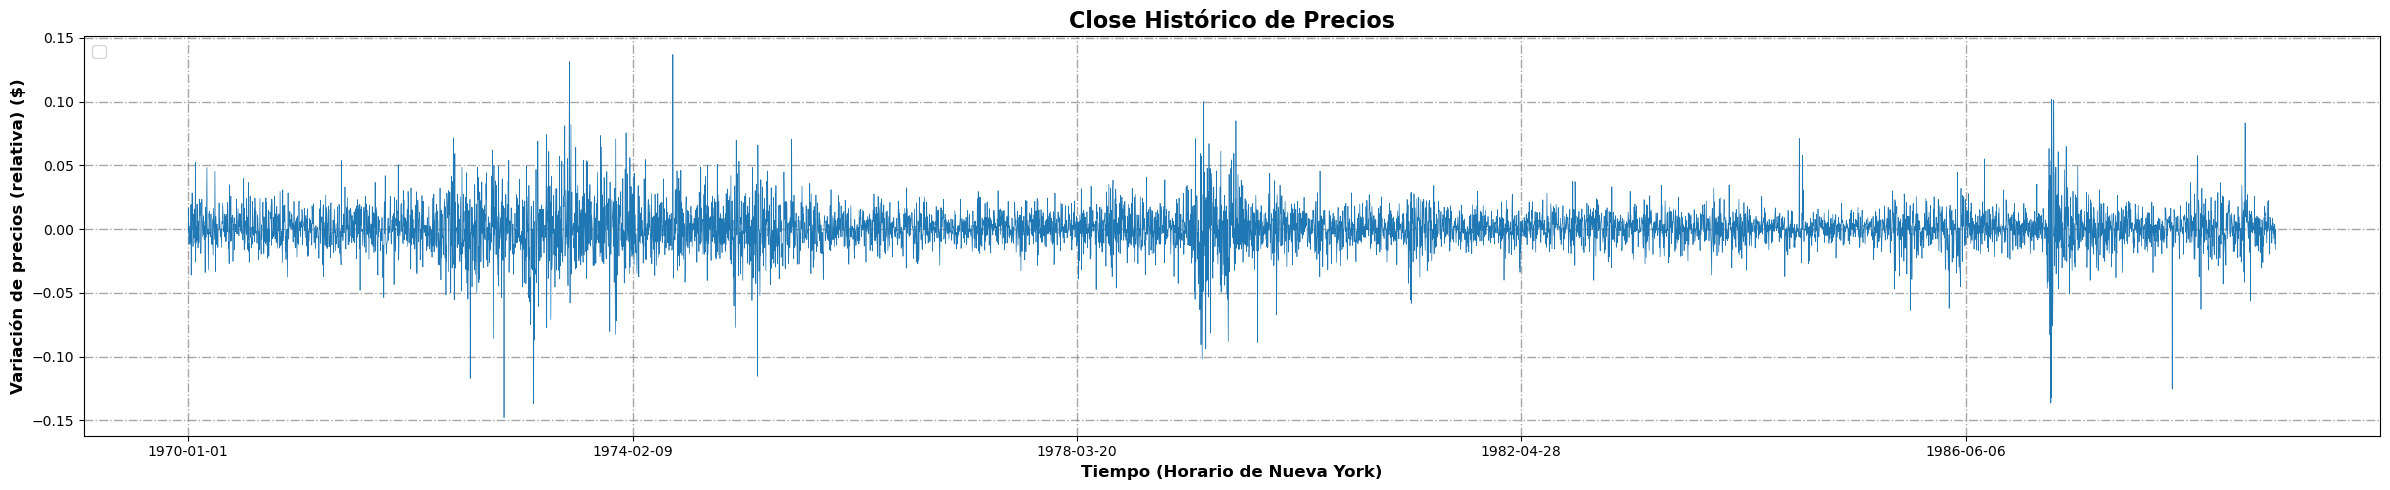

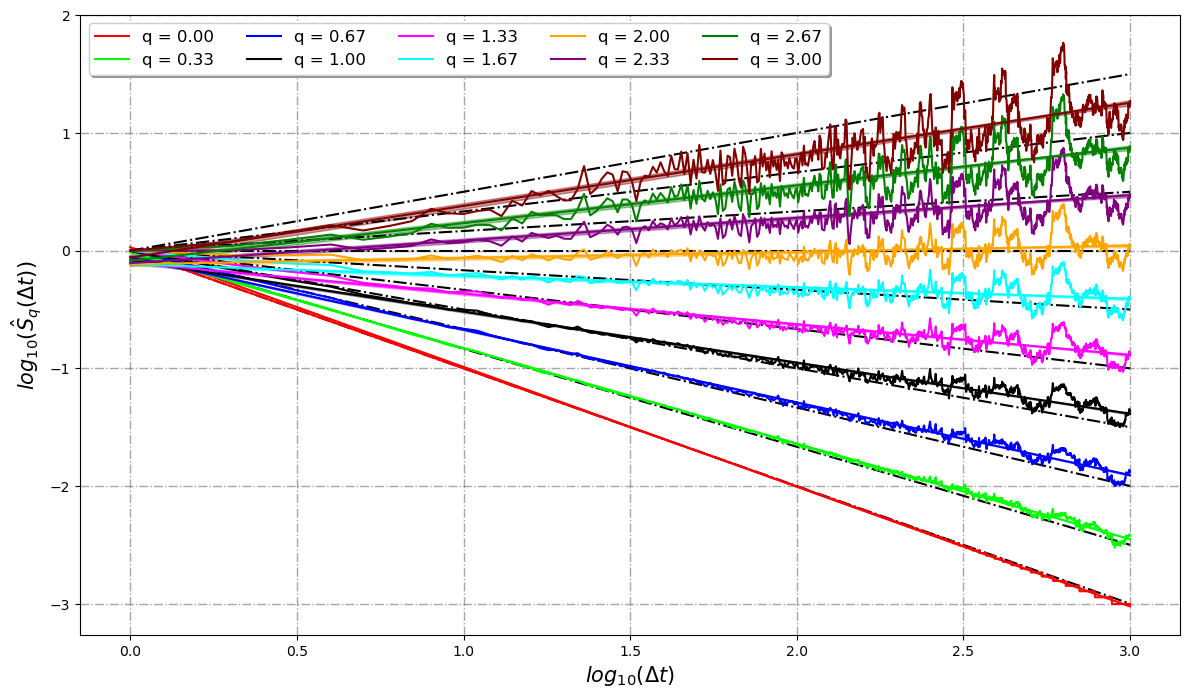

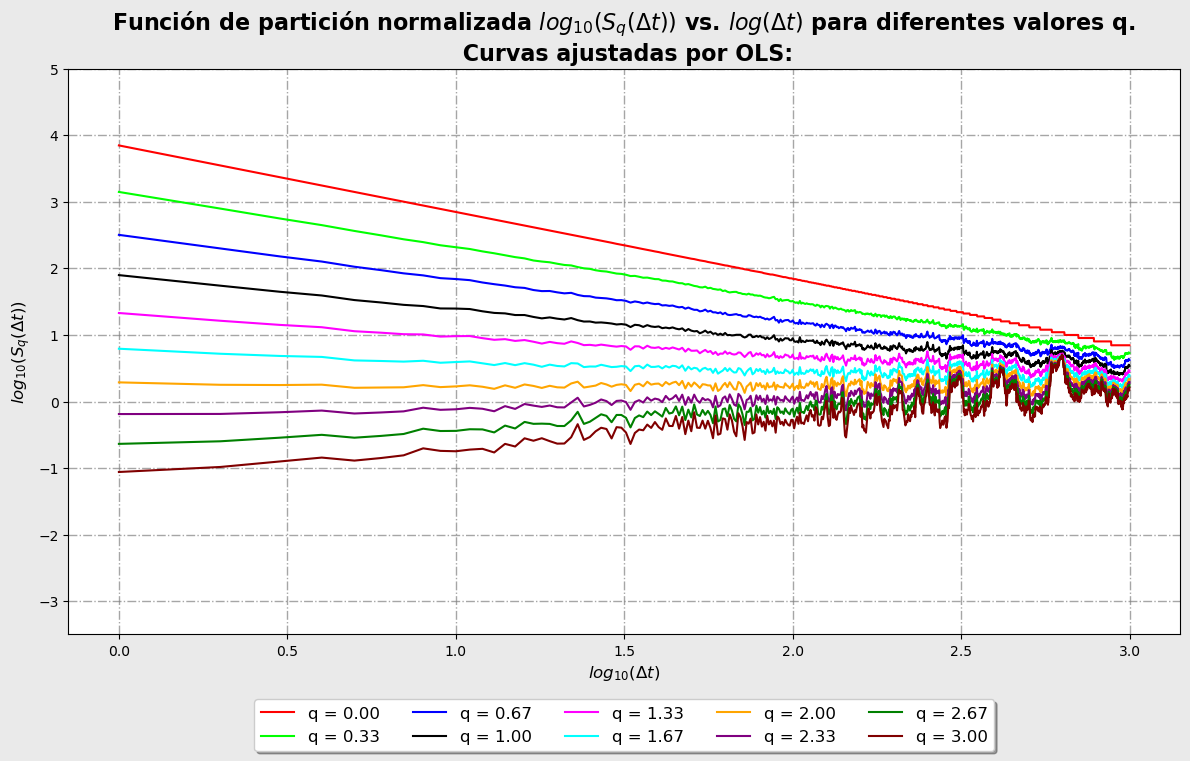

<Figure size 640x480 with 0 Axes>

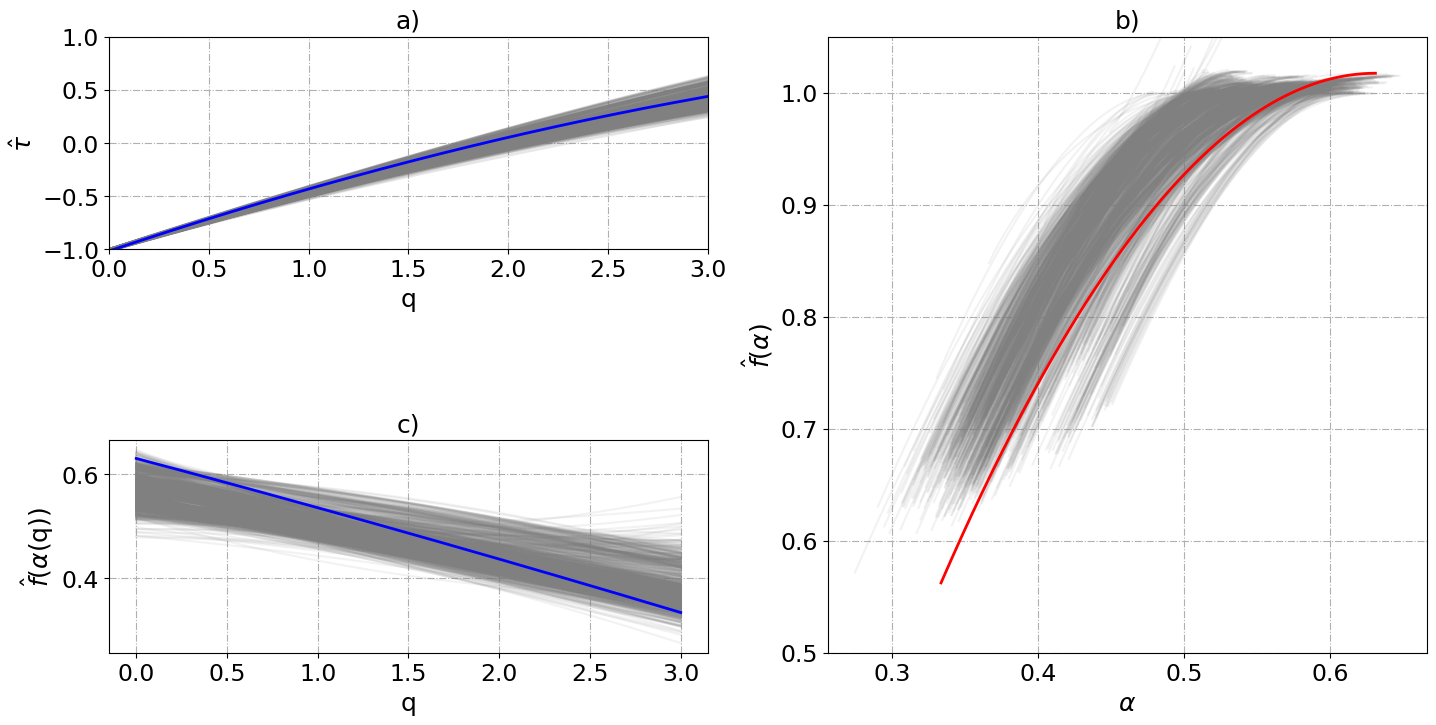

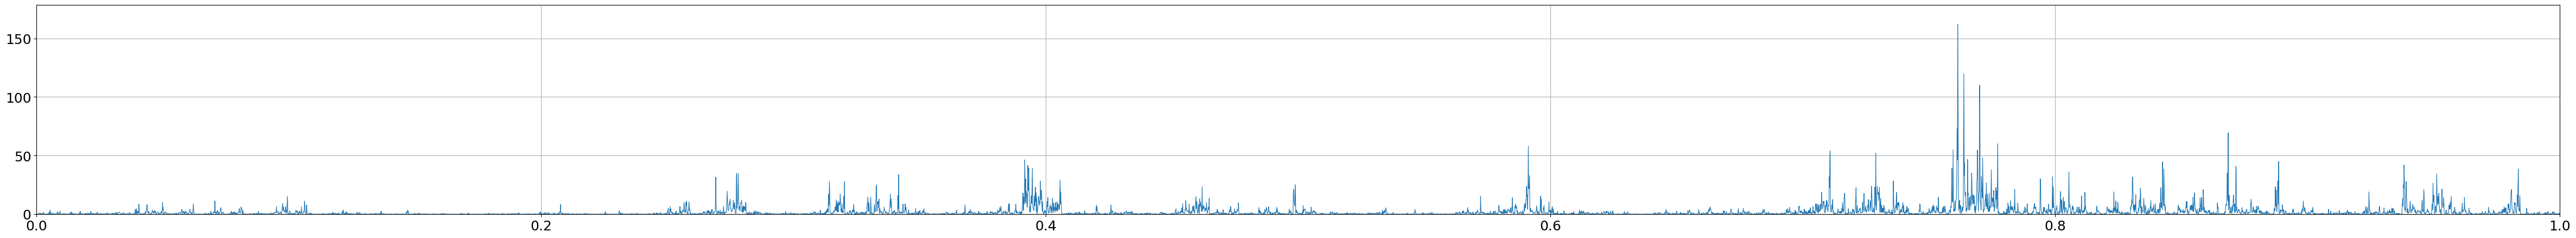

In [10]:
Lockheed = MMAR(df, "Date", "Close", a = 0, b = 3, npuntos=10)
Lockheed.grafPrice()
Lockheed.grafX_t()
Lockheed.graf_Price_change()
Lockheed.Partition_functions()
Lockheed.tauandalpha()
Lockheed.multifractal_measure_rand(graf1 = True)

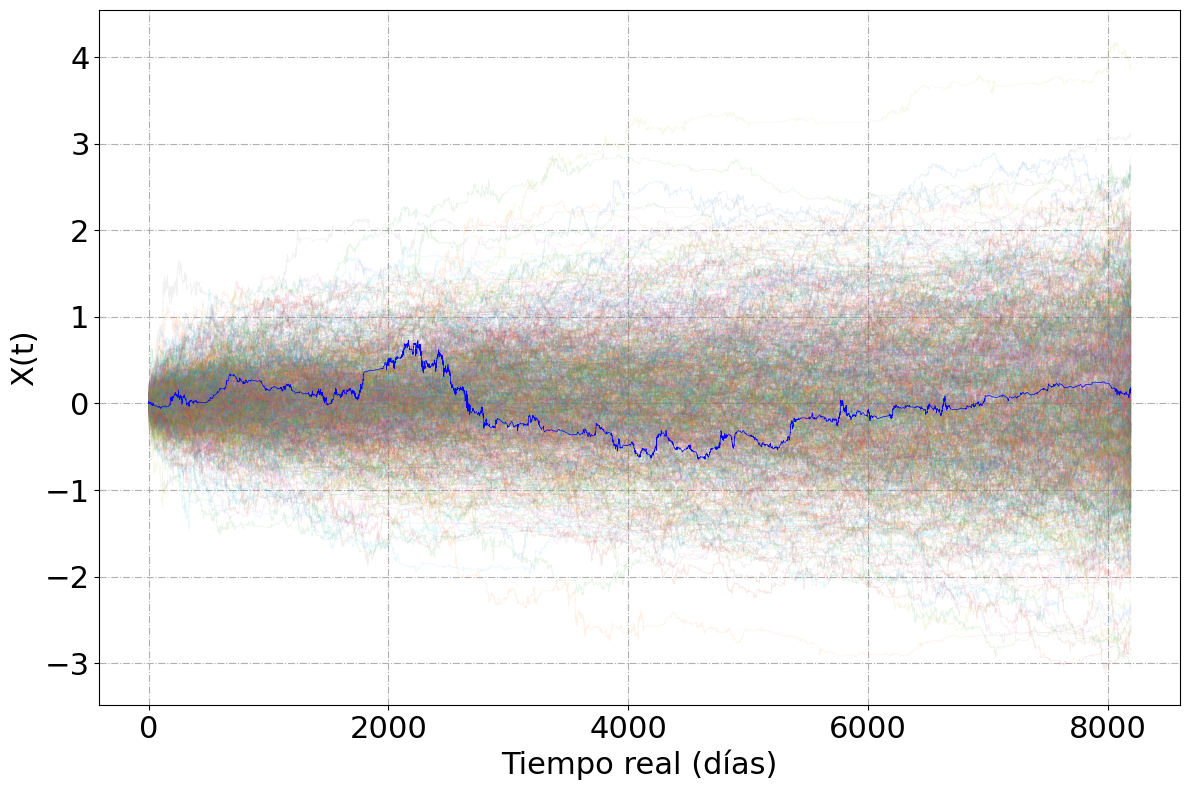

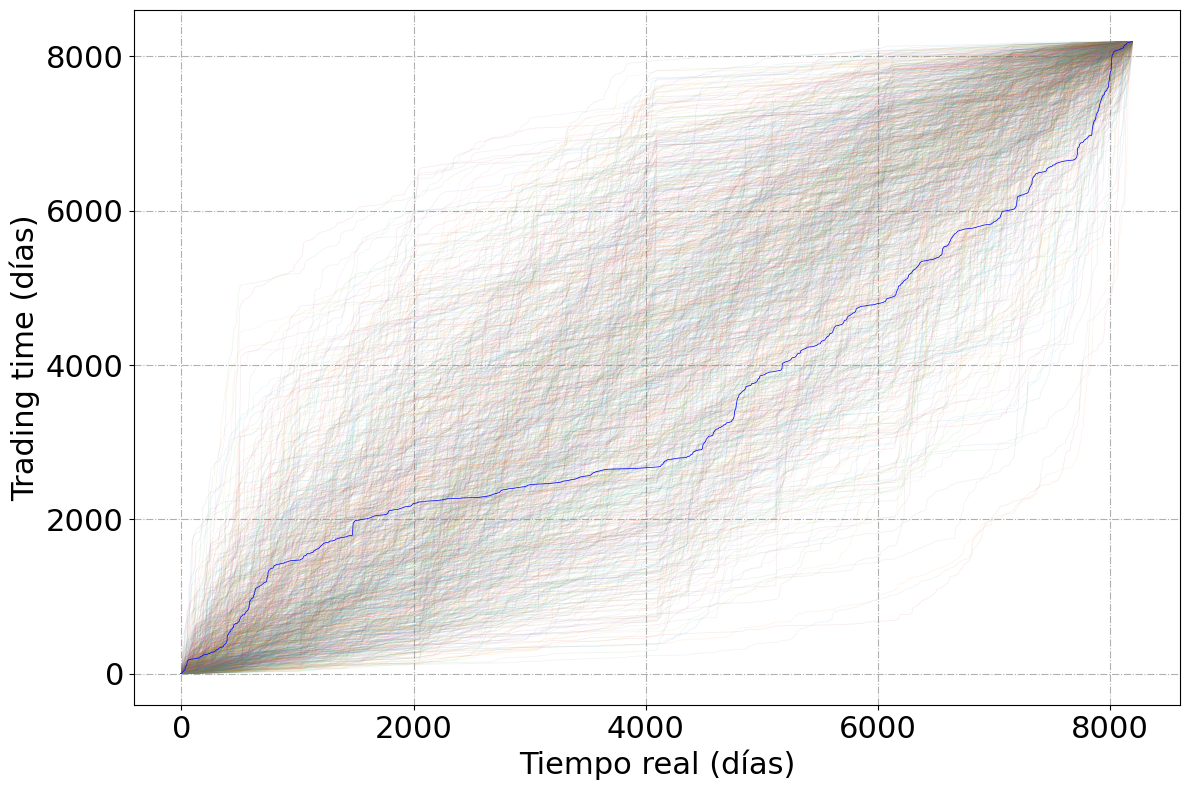

In [11]:
x, y, z = Lockheed.simulacion2(n = 1000)

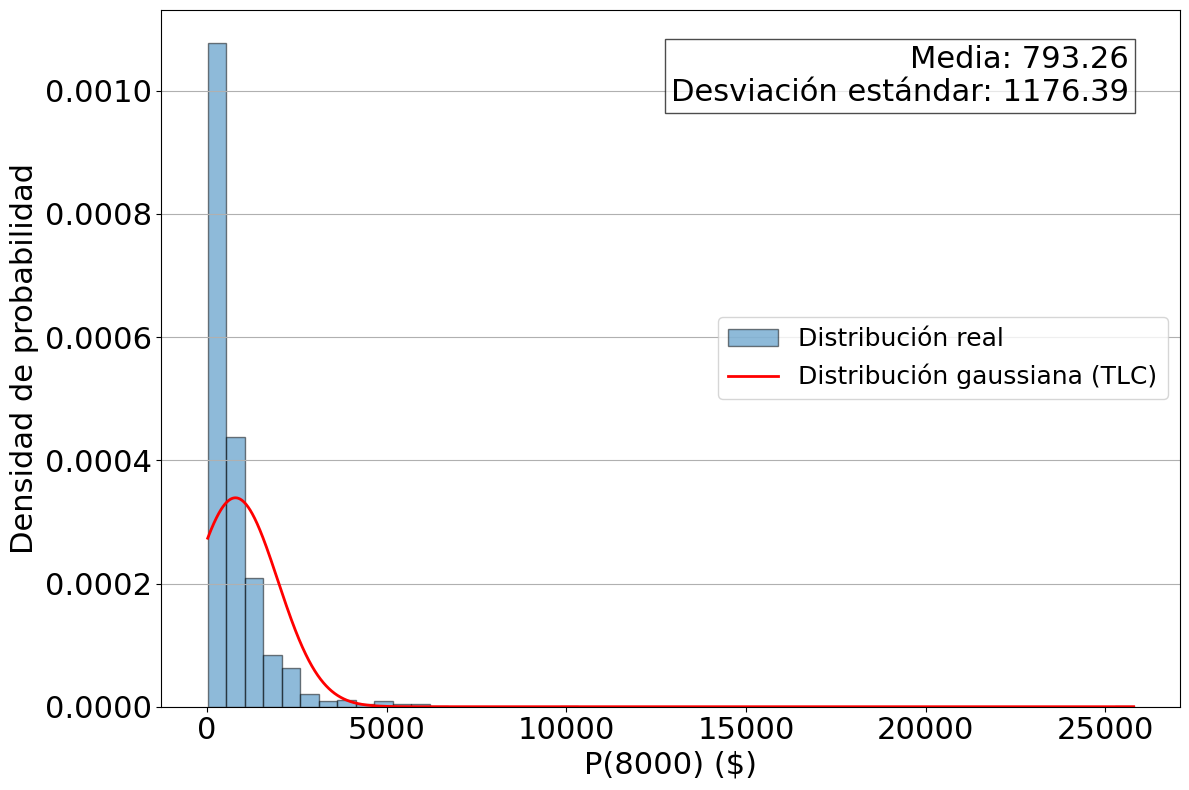

In [12]:
Lockheed.analizadorprobabilidades(8000, x, y)

# Apple

Los valores de los ajustes (a,m respectivame) son [array([-0.95474383,  0.02606853]), array([-0.85927209,  0.0111598 ]), array([-0.7649451 , -0.00460171]), array([-0.67177775, -0.02105864]), array([-0.57982879, -0.03798981]), array([-0.48917594, -0.05518153]), array([-0.39991064, -0.07245551]), array([-0.31213903, -0.0896878 ]), array([-0.2259842 , -0.10683069]), array([-0.14158818, -0.12394242]), array([-0.05911222, -0.14122528]), array([ 0.02126518, -0.15906846]), array([ 0.09935357, -0.17808554]), array([ 0.17495975, -0.19912876]), array([ 0.2479011, -0.2232551]), array([ 0.31802268, -0.25162151]), array([ 0.38521579, -0.28530539]), array([ 0.44943457, -0.3250842 ]), array([ 0.51070637, -0.37124626]), array([ 0.56913243, -0.42351106])]
Los errores asociados a la ordenada (término independiente) vienen dados por [-0.0018555243735062855, -0.002674043559817981, -0.0034463801189244655, -0.004126742698805792, -0.004743863820579066, -0.005323107908545606, -0.00588101104222864, -0.00642822

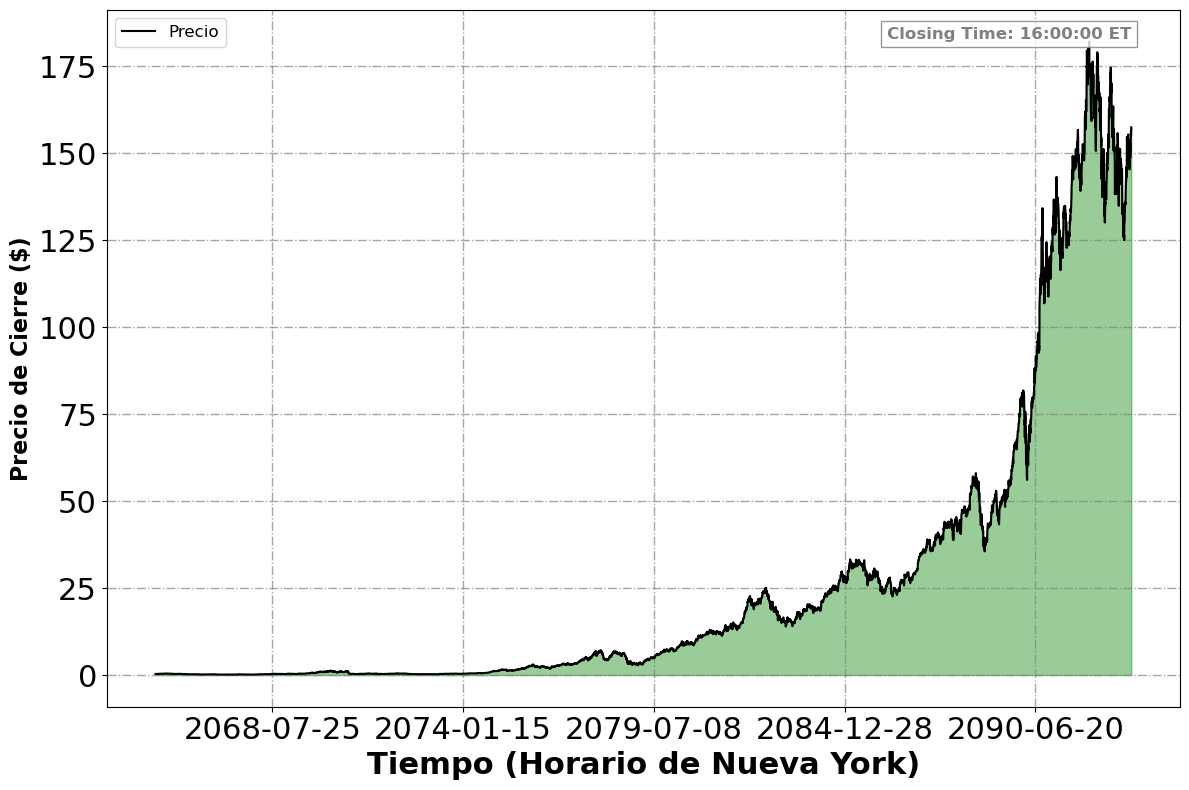

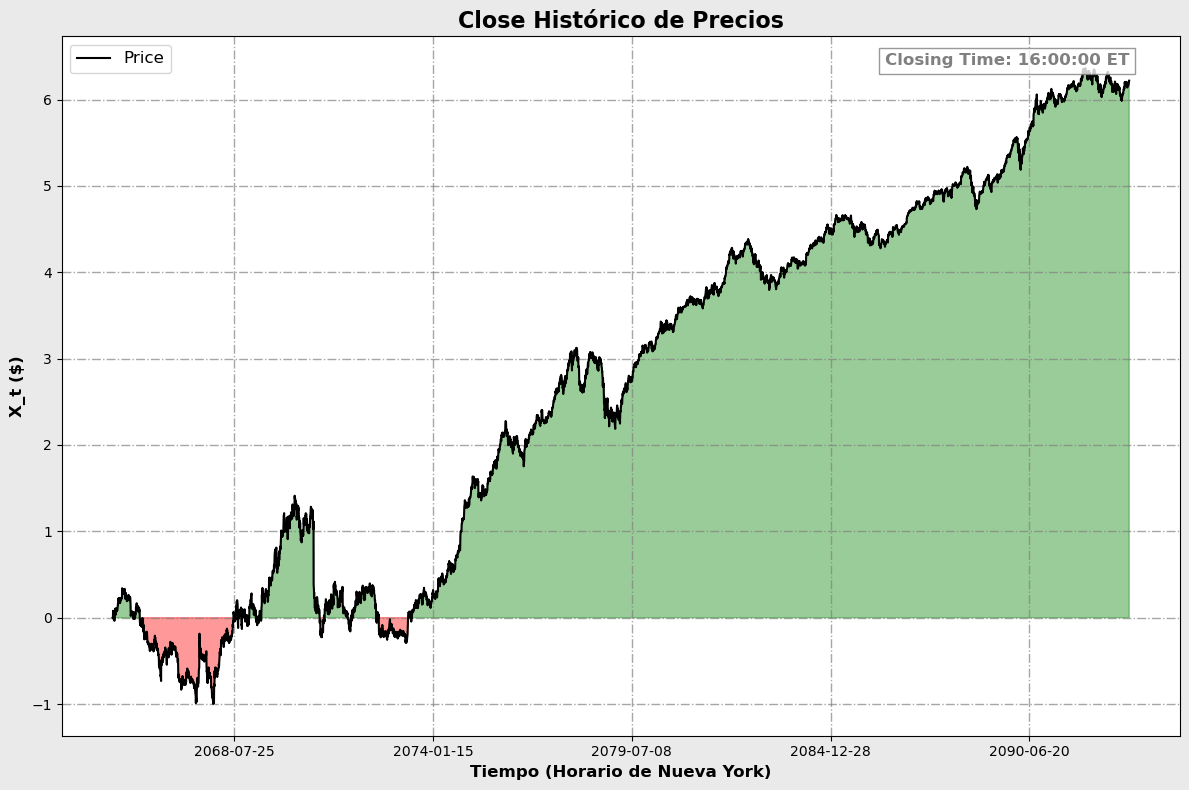

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


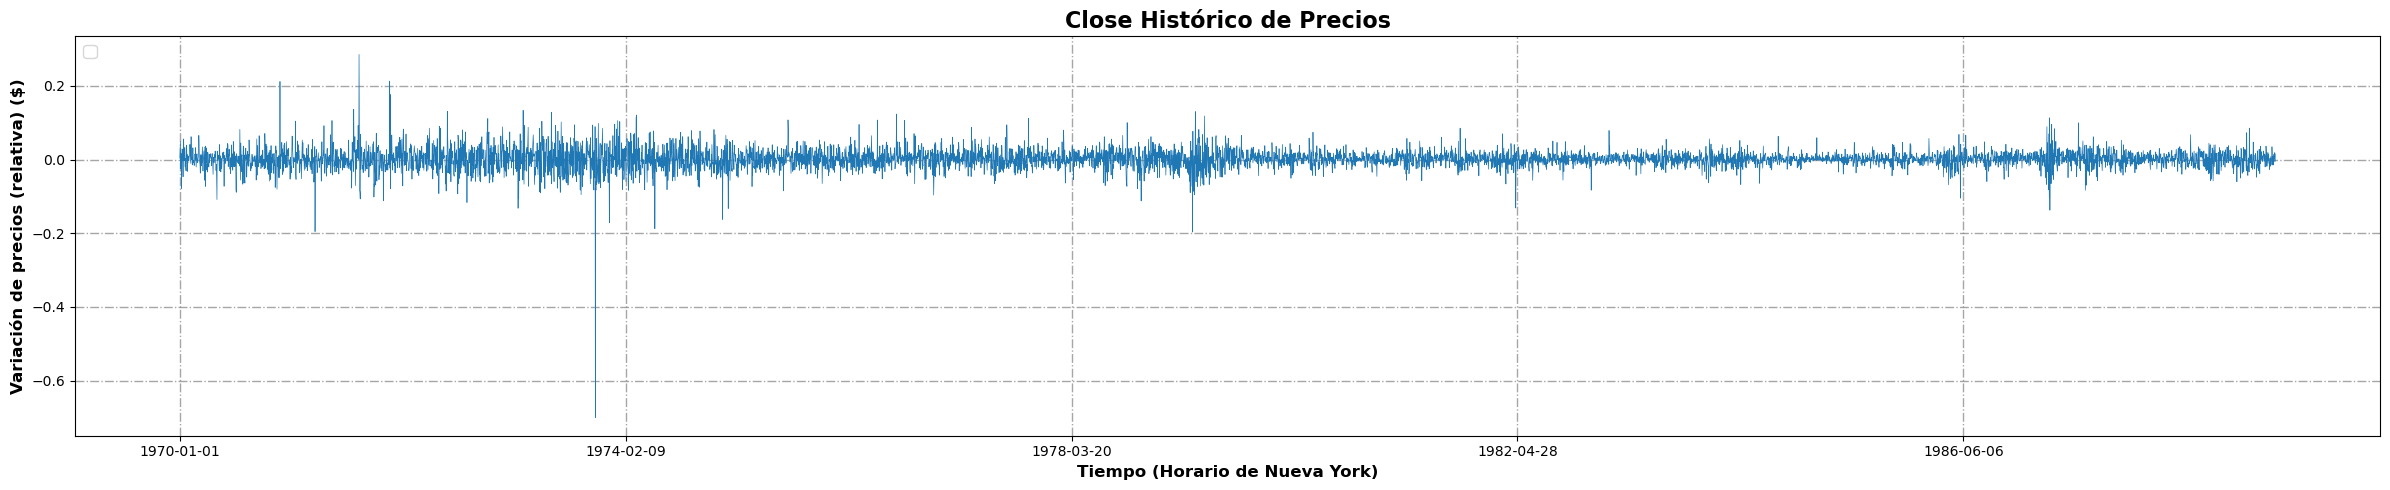

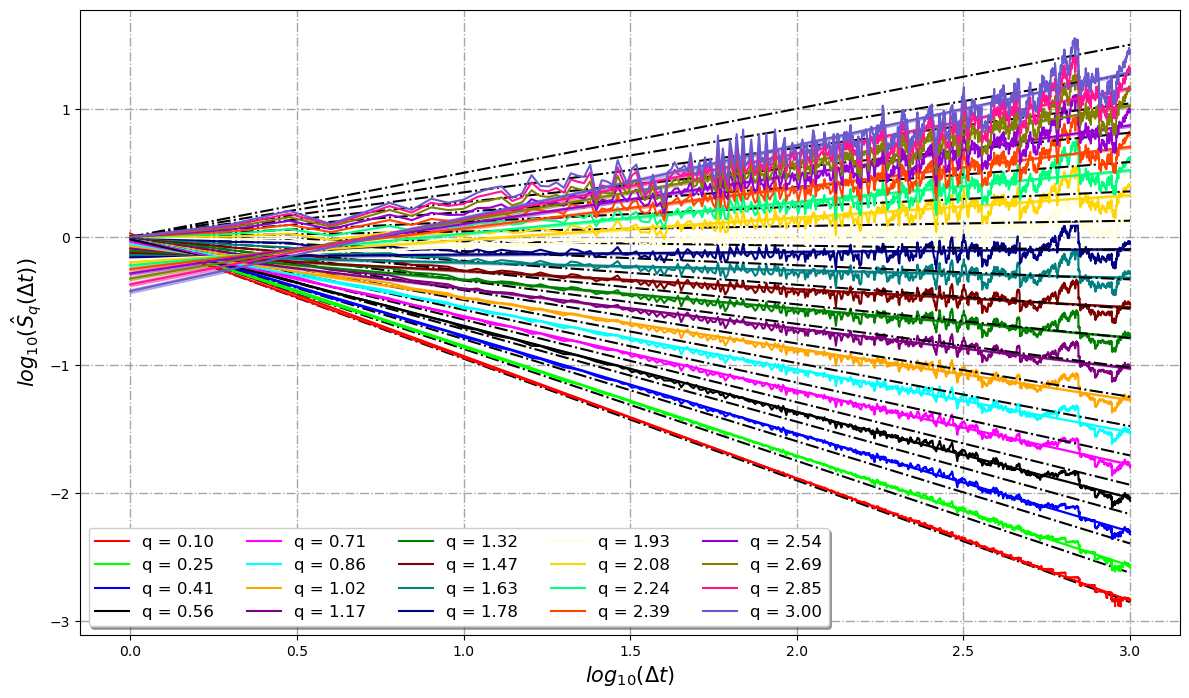

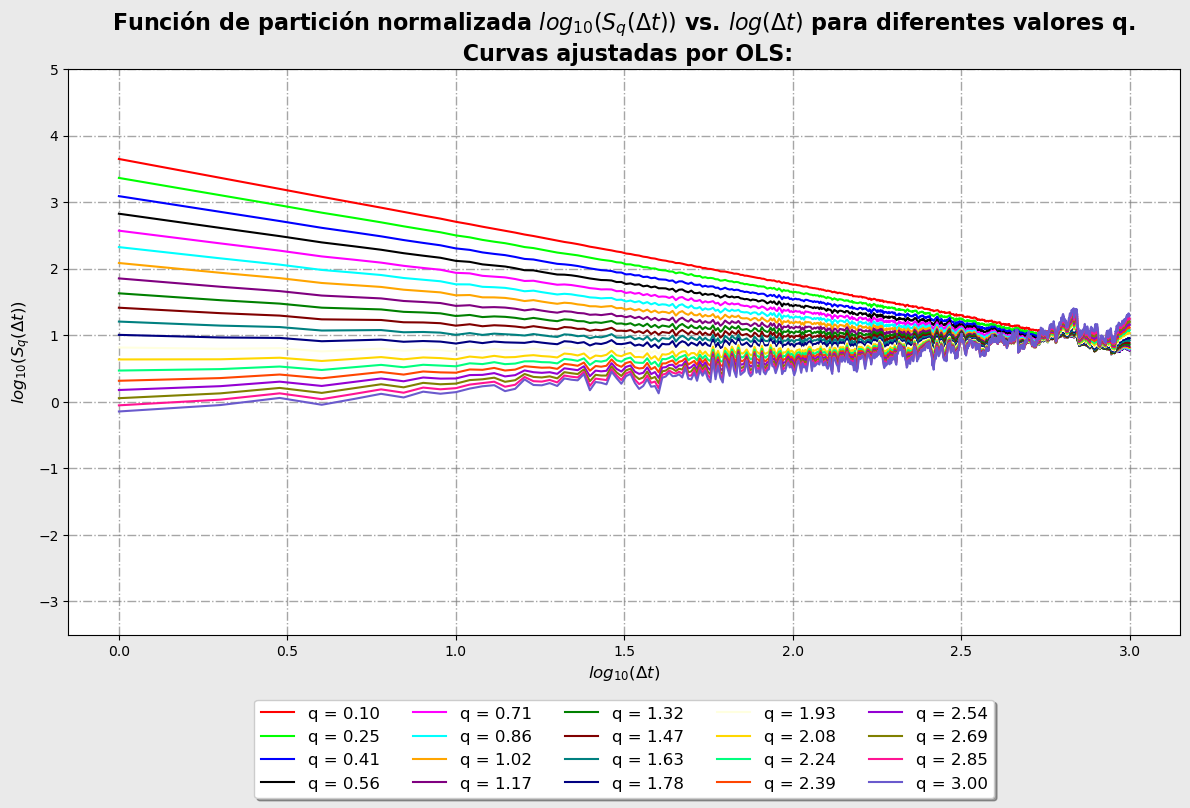

<Figure size 640x480 with 0 Axes>

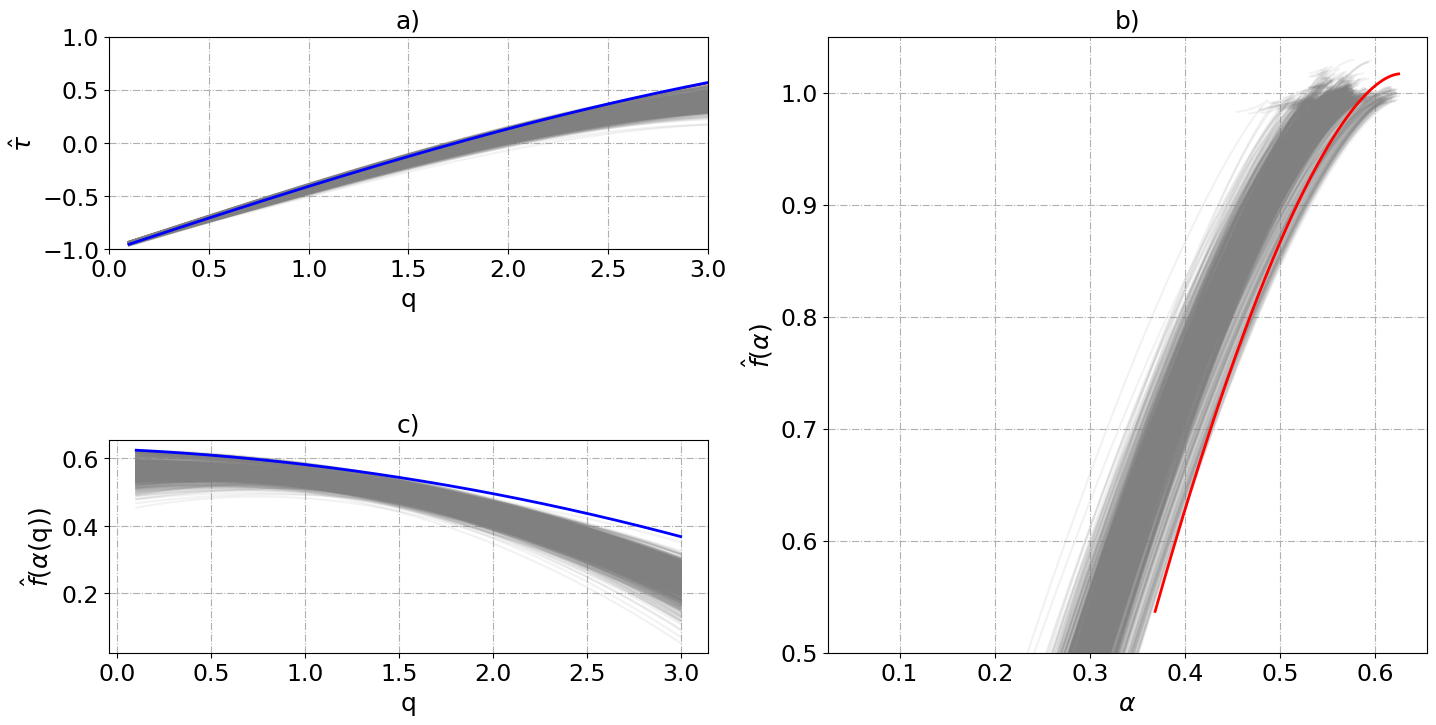

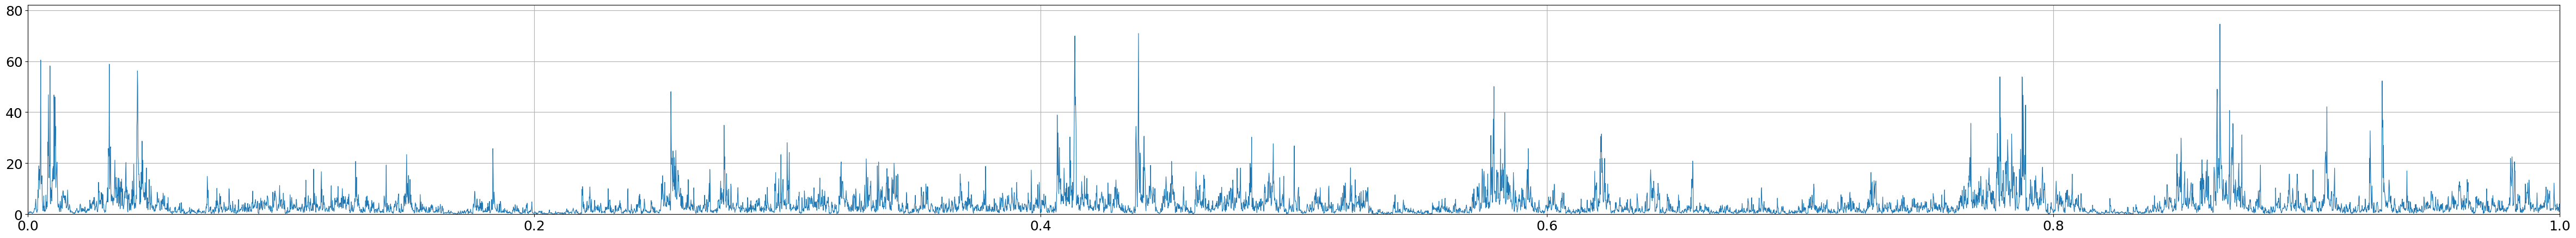

In [7]:
df1 = pd.read_excel("/Users/omarkhalil/Desktop/Universidad/TFG/Simulacion_Omar/Datos_para_simulacion/Apple.xlsx")
Apple = MMAR(df1, "Date", "Close", a = 0.1, b = 3, npuntos = 20)
Apple.grafPrice()
Apple.grafX_t()
Apple.graf_Price_change()
Apple.Partition_functions()
Apple.tauandalpha()
Apple.multifractal_measure_rand(graf1 = True)

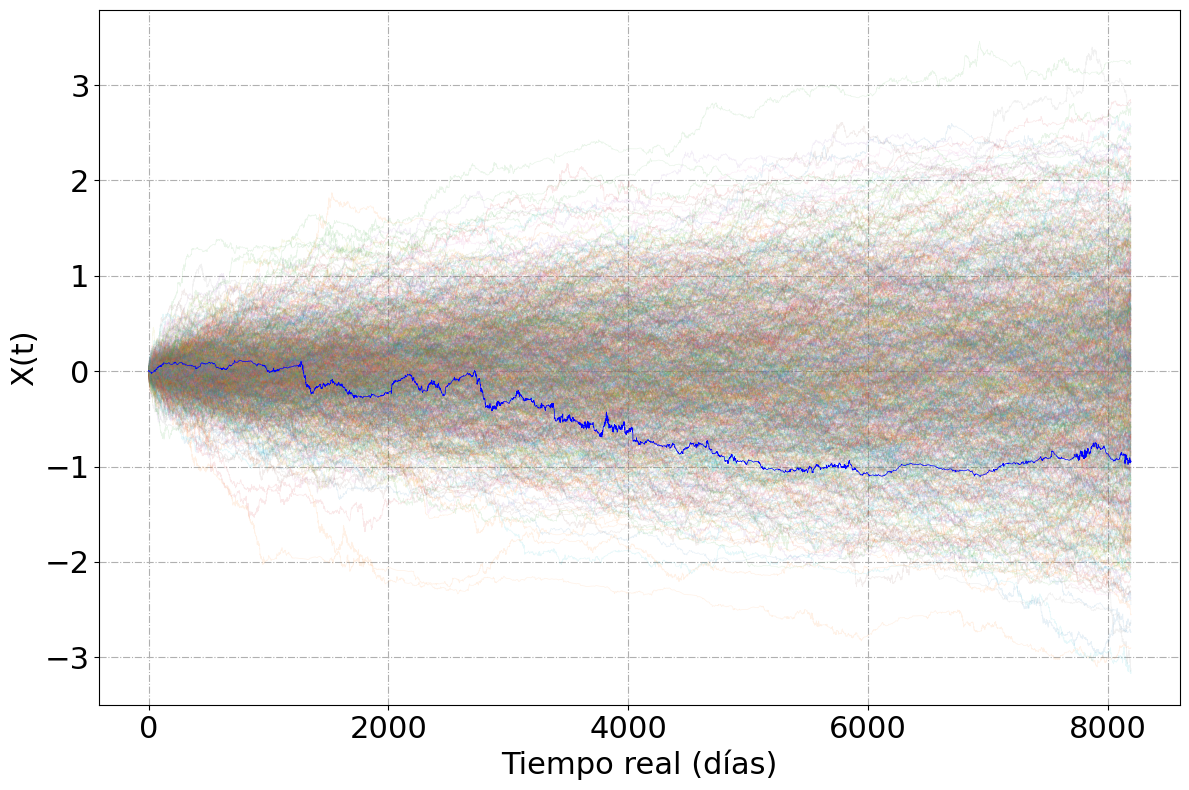

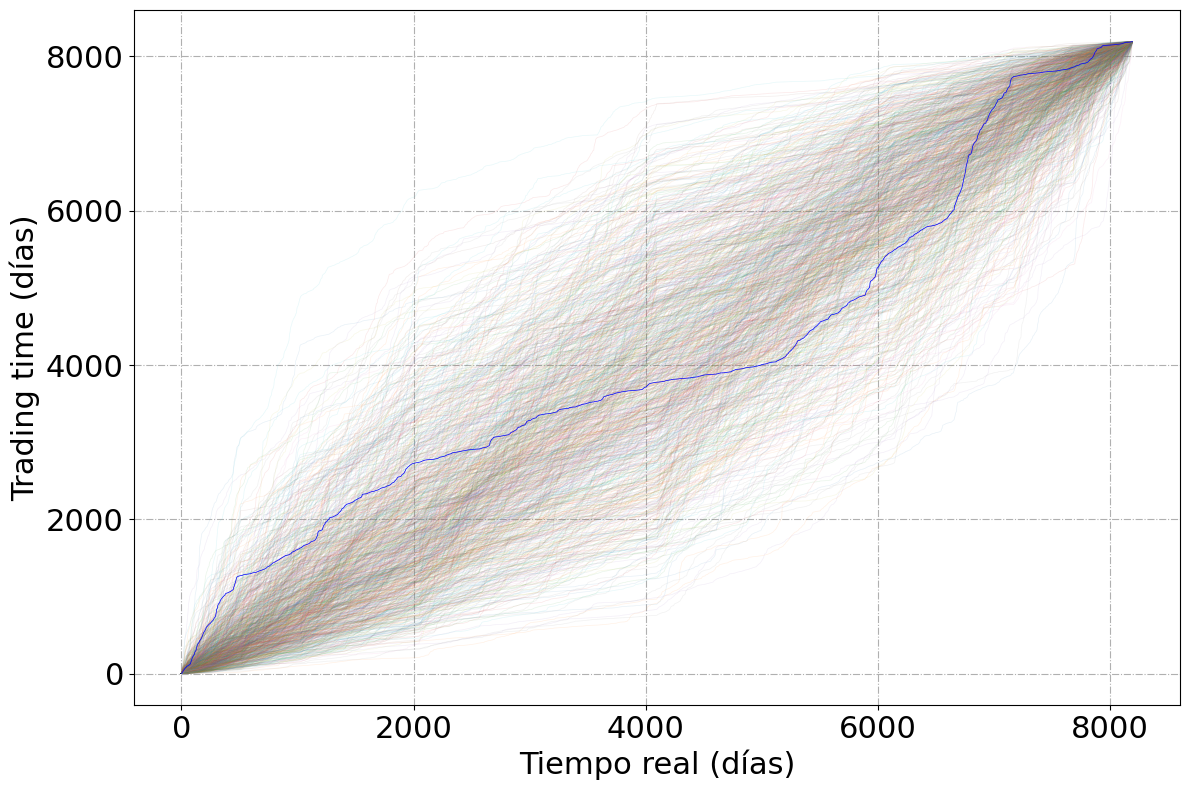

In [8]:
x, y, z = Apple.simulacion2(n = 1000)

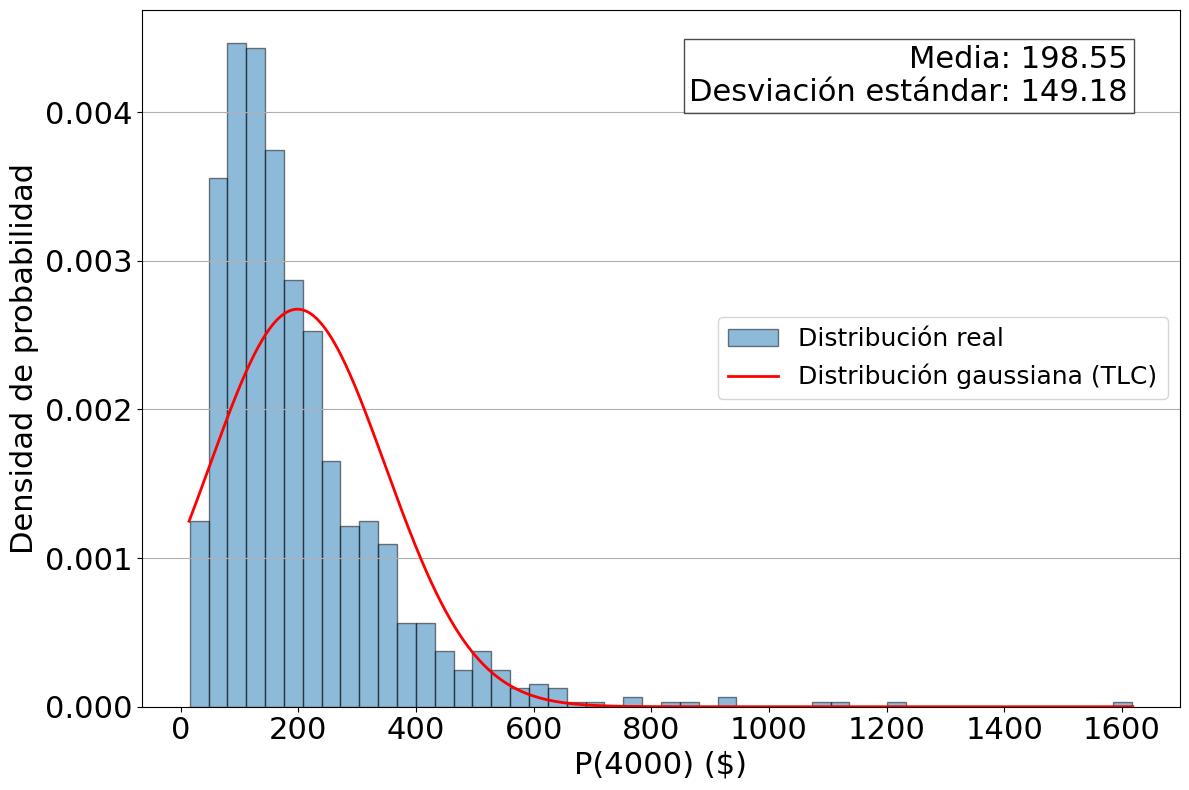

In [11]:
Apple.analizadorprobabilidades(4000, x, y)